In [1]:
import os
import glob
import time

import pandas as pd
import numpy as np
import xarray as xr
import datetime


import matplotlib
from matplotlib import pyplot as plt
from matplotlib.ticker import NullFormatter
%matplotlib inline
matplotlib.rcParams.update({'font.size': 16})

import cartopy.crs as ccrs
import cartopy

from wrf_hr_utils import *
from wrfProcessing import *

import sys
p = os.path.abspath('../..')
if p not in sys.path:
    sys.path.append(p)

from orographicPrecipitation.precip_model_functions import qsat,humidsat
from orographicConvectionTheory.orographicConvectionTheory import *
SCRATCH='/global/cscratch1/sd/qnicolas/'

import metpy.calc as mpcalc
from metpy.plots import SkewT
from metpy.units import units

In [2]:
xr.set_options(display_style='text') 

# Functions, data

In [3]:
hrchannel = extract_wrfout('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/')
hrchannel_p = extract_wrfpro('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/')
hrchannelprecip=xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.precip.days0-200.nc')

hrchannel11 = extract_wrfsub('/global/cfs/projectdirs/m3310/qnicolas/wrf_saved/channel.wrf.100x2.mountain.11mps.3km/')
hrchannel11precip=xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.11mps.3km/diags/wrf.precip.days0-150.nc')

In [4]:
deepchannel_p = extract_wrfpro('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.3km/')


In [4]:
lmbegin_9_300 = xr.open_dataset('/global/cfs/projectdirs/m3310/qnicolas/wrf_saved/channel.wrf.100x2.mountain.500m.9mps.3km/wrfout_d01_1970-01-01_00_00_00_initialtime.nc')
lmchannel_9_300 = extract_wrfsub('/global/cfs/projectdirs/m3310/qnicolas/wrf_saved/channel.wrf.100x2.mountain.500m.9mps.3km/')
lmchannel_9_300p = extract_wrfpro('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.9mps.3km/')
lmchannel_9_300precip  = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.9mps.3km/diags/wrf.precip.days0-400.nc')

lmchannel_11_300 = extract_wrfsub('/global/cfs/projectdirs/m3310/qnicolas/wrf_saved/channel.wrf.100x2.mountain.500m.11mps.3km/')
lmchannel_11_300p = extract_wrfpro('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.11mps.3km/')
lmchannel_11_300precip = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.11mps.3km/diags/wrf.precip.days0-400.nc')

lmchannel_11_302 = extract_wrfsub('/global/cfs/projectdirs/m3310/qnicolas/wrf_saved/channel.wrf.100x2.mountain.500m.11mps.302K.3km/')
lmchannel_11_302p = extract_wrfpro('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.11mps.302K.3km/')
lmchannel_11_302precip = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.11mps.302K.3km/diags/wrf.precip.days0-600.nc')

lmchannel_11_298 = extract_wrfout('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.11mps.298K.3km/')
lmchannel_11_298p = extract_wrfpro('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.11mps.298K.3km/')
lmchannel_11_298precip = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.11mps.298K.3km/diags/wrf.precip.days0-600.nc')


In [5]:
hrhgt = hrchannel.HGT.isel(south_north=0,Time=-1).persist()
hrdist=(1635-hrhgt.west_east)*3

In [6]:
def ratio_CI(pr1,pr2,unit,norm=1):
    pr1=np.array(pr1); pr2=np.array(pr2)
    nt1=len(pr1);nt2=len(pr2)
    sigma1=np.std(pr1.mean(axis=(1,2)));sigma2=np.std(pr2.mean(axis=(1,2)))
    
    meanratio = pr2.mean()/pr1.mean()
    deltaratio = meanratio * np.sqrt( (2*sigma1/np.sqrt(nt1)/pr1.mean())**2 + (2*sigma2/np.sqrt(nt2)/pr2.mean())**2)
    
    print("Change is %.1f %%/%s (95%% CI = [%.1f to %.1f])"%(100*(meanratio-1)/norm,unit,100*(meanratio-1-deltaratio)/norm,100*(meanratio-1+deltaratio)/norm))

In [208]:
def compute_N(T,pfactor,pname='pressure'):
    """T in K, p in Pa and N in s"""
    g = 9.81; R=287.
    rho = pfactor*T[pname]/R/T
    theta = T*(pfactor*T[pname]/1e5)**(-0.287)
    return np.sqrt(-rho*g*g/theta*theta.differentiate(pname)/pfactor)

def linear_precip_theory_N(xx,hx,U,N,qfact=1,tauT=3,tauq=11,P0=4.,Td_effect=1,m_effect=1):
    pT_ov_g = 8e3 #mass of troposphere in kg/m2
    
    z=np.arange(0,10000,100)
    k=k_vector(len(xx),xx[1]-xx[0])
    
    tauT*=3600
    tauq*=3600
    
    Lq=compute_Lq(5,U,tauq)
    
    _,dq0dz,_ = lapse_rates()
    N0=0.01
    if Td_effect:
        ds0dz = cp*300/g*N**2
    else:
        ds0dz = cp*300/g*N0**2
    chi = pT_ov_g * (ds0dz/tauT - qfact*dq0dz/tauq)/ Lc * 86400
    
    if not m_effect:
        N=N0
    
    zbot=1000
    ztop=3000    
    z_slice = z[np.where((z>=zbot) & (z<=ztop))]
    Pprimehat = 1j*k/(1j*k + 1/Lq) * chi * np.fft.fft(hx) * np.exp( m_exponent(k[:,None],N,U)  *  z_slice[None,:]).mean(axis=1) 
    
    P = P0 + np.real(np.fft.ifft(Pprimehat))
    P = np.maximum(0.,P)
    return P

def linear_TdL_qdL_N(xx,hx,U,N,qfact=1):
    cp = 1004. #Heat capacity of air in J/kg/K

    z=np.arange(0,10000,100)
    k=k_vector(len(xx),xx[1]-xx[0])

    zbot=1000
    ztop=3000
    z_slice = z[np.where((z>=zbot) & (z<=ztop))]

    _,dq0dz,_ = lapse_rates()
    dq0dz *= qfact
    ds0dz = cp*300/g*N**2

    Tdhat = -ds0dz*np.fft.fft(hx)*np.exp( m_exponent(k[:,None],N,U)  *  z_slice[None,:]).mean(axis=1)
    qdhat = -dq0dz*np.fft.fft(hx)*np.exp( m_exponent(k[:,None],N,U)  *  z_slice[None,:]).mean(axis=1)

    return np.real(np.fft.ifft(Tdhat))/cp,np.real(np.fft.ifft(qdhat))/cp

from scipy.integrate import cumtrapz
def linear_w_N(xx,hx,U,N,vert_coord='z'):
    top=15e3
    Nz=100
    
    z=np.linspace(0,top,Nz)
    k=k_vector(len(xx),xx[1]-xx[0])
    h_hat = np.fft.fft(hx)
    
    w_hat = 1j*k[:,None]*U*h_hat[:,None]*np.exp( m_exponent(k[:,None],N,U)  *  z[None,:]) 
    if vert_coord=='z':
        w=xr.DataArray(np.real(np.fft.ifft(w_hat,axis=0)),coords={'distance_from_mtn':xx/1000,'altitude':z/1000},dims=['distance_from_mtn','altitude'])
    elif vert_coord=='p':
        p = 1000*np.exp(-9.81/287.*cumtrapz(1/(300-6.5e-3*z),z,initial=0.))
        w=xr.DataArray(np.real(np.fft.ifft(w_hat,axis=0)),coords={'distance_from_mtn':xx/1000,'pressure':p},dims=['distance_from_mtn','pressure'])
    return w

def hatprime(var,idx1,idx2):
    """Vertically average variable between two pressure levels indicated by their indices (idx1 and idx2), and take deviation from upstream value"""
    varhat = var[idx1:idx2].integrate('pressure')/(var.pressure[idx2]-var.pressure[idx1])
    return varhat - varhat[2200:2400].mean('distance_from_mtn')
pT_ov_g=8000
cp=1004.
Lc=2.5e6
g=9.81

# Sensitivity to U 

## Theory

### Maxs and sensitivities

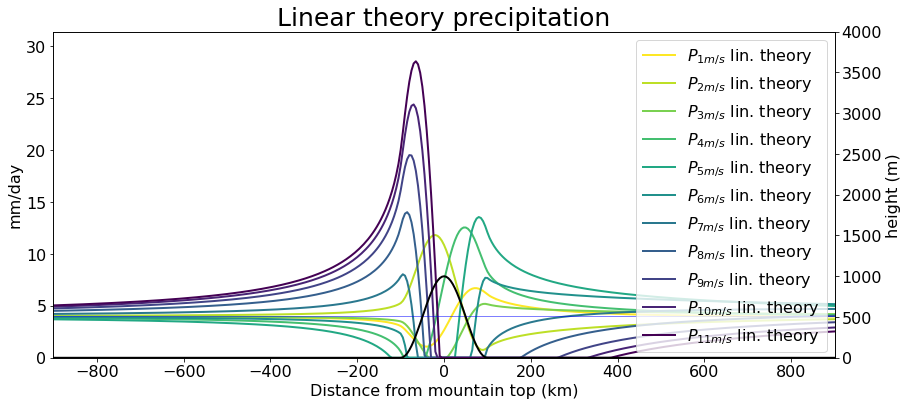

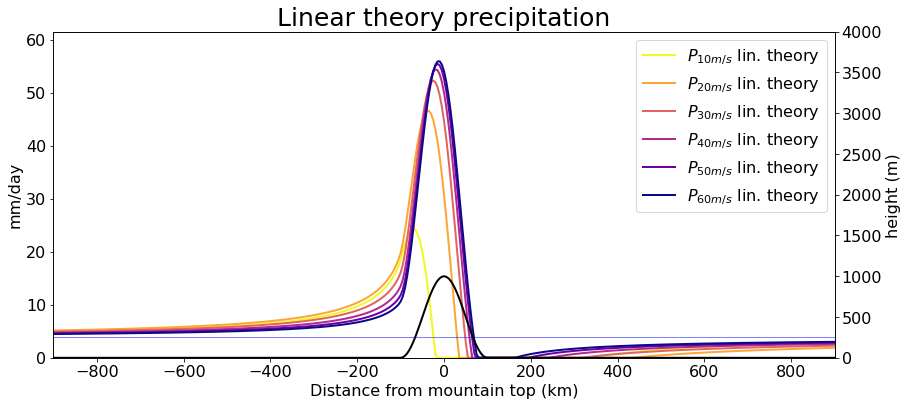

In [83]:
u_arrays=[np.arange(1,12,1),np.arange(10,70,10)]
clr_arrays=[plt.cm.viridis(np.linspace(0,1,11))[::-1],plt.cm.plasma(np.linspace(0,1,6))[::-1]]
for us,clrs in zip(u_arrays,clr_arrays):
    fig,ax=plt.subplots(1,1,figsize=(14,6))
    ax2=ax.twinx()
    lw=2
    x,hx = topographic_profile(kind='cos')
    for u,clr in zip(us,clrs):
        Plin = linear_precip_theory(x,hx,u,tauT=7.5,tauq=27.5,P0 = 4.)
        ax.plot(x/1000,Plin,label = r"$P_{%i m/s}$ lin. theory"%u,linewidth=lw,color=clr)
    # mountain
    ax2.plot(x/1000,hx,label=r"$h(x)$",color='k',linewidth=2)
    
    ax.axhline(4.,linestyle='-',linewidth=0.5,color='b')
    ax.set_xlabel('Distance from mountain top (km)')
    ax.set_ylabel('mm/day')
    ax2.set_ylabel('height (m)')
    ax.set_xlim(-900,900)
    ax.set_ylim(0,np.max(Plin)*1.1)
    ax2.set_ylim(0,4000)
    ax.legend(loc=1)
    ax.set_title('Linear theory precipitation',fontsize=25)


In [91]:
us = np.arange(1,40,0.5)
maxs = np.zeros(len(us));means200 = np.zeros(len(us));means1000 = np.zeros(len(us))


x,hx = topographic_profile(kind='cos')
idxm200=np.argmin((x+200e3)**2)
idxm1000=np.argmin((x+1000e3)**2)
idx100=np.argmin((x-100e3)**2)
for i,u in enumerate(us):
    Plin = linear_precip_theory(x,hx,u,tauT=7.5,tauq=27.5,P0 = 4.)
    maxs     [i] = np.max(Plin)
    means200 [i] = np.mean(Plin[idxm200:idx100]-4)
    means1000[i] = np.mean(Plin[idxm1000:idx100]-4)
        
dlnmaxdu = (maxs[2:]/maxs[:-2] - 1)*100
dlnmeans200du = (means200[2:]/means200[:-2] - 1)*100
dlnmeans1000du = (means1000[2:]/means1000[:-2] - 1)*100
   

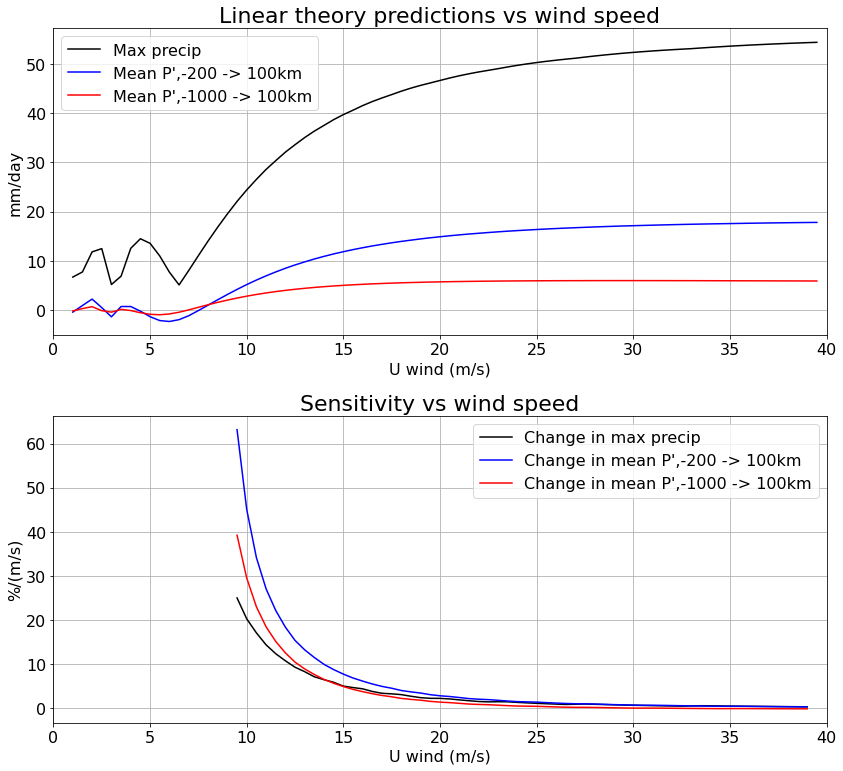

In [97]:
fig,(ax,ax2)=plt.subplots(2,1,figsize=(12,11))
ax.plot(us,maxs,color='k',label="Max precip")
ax.plot(us,means200,color='b',label="Mean P',-200 -> 100km")
ax.plot(us,means1000,color='r',label="Mean P',-1000 -> 100km")
ax.grid()
ax.set_xlabel('U wind (m/s)')
ax.set_ylabel('mm/day')
ax.set_title("Linear theory predictions vs wind speed",fontsize=22)
ax.legend(loc=2)

ax2.plot(us[17:-1],dlnmaxdu[16:],color='k',label="Change in max precip")
ax2.plot(us[17:-1],dlnmeans200du[16:],color='b',label="Change in mean P',-200 -> 100km")
ax2.plot(us[17:-1],dlnmeans1000du[16:],color='r',label="Change in mean P',-1000 -> 100km")
ax2.grid()
ax2.set_xlabel('U wind (m/s)')
ax2.set_ylabel('%/(m/s)')
ax2.set_title("Sensitivity vs wind speed",fontsize=22)
ax2.legend(loc=1)

ax.set_xlim(0,40)
ax2.set_xlim(0,40)
fig.tight_layout()

### W profiles

In [98]:
def levs(wmax,n):
    x=np.linspace(-wmax**(1/n),wmax**(1/n),40)
    return np.sign(x)*np.abs(x)**n

wlevs=levs(0.03,2)
wticks=[-.03,-.01,0.,.01,.03]

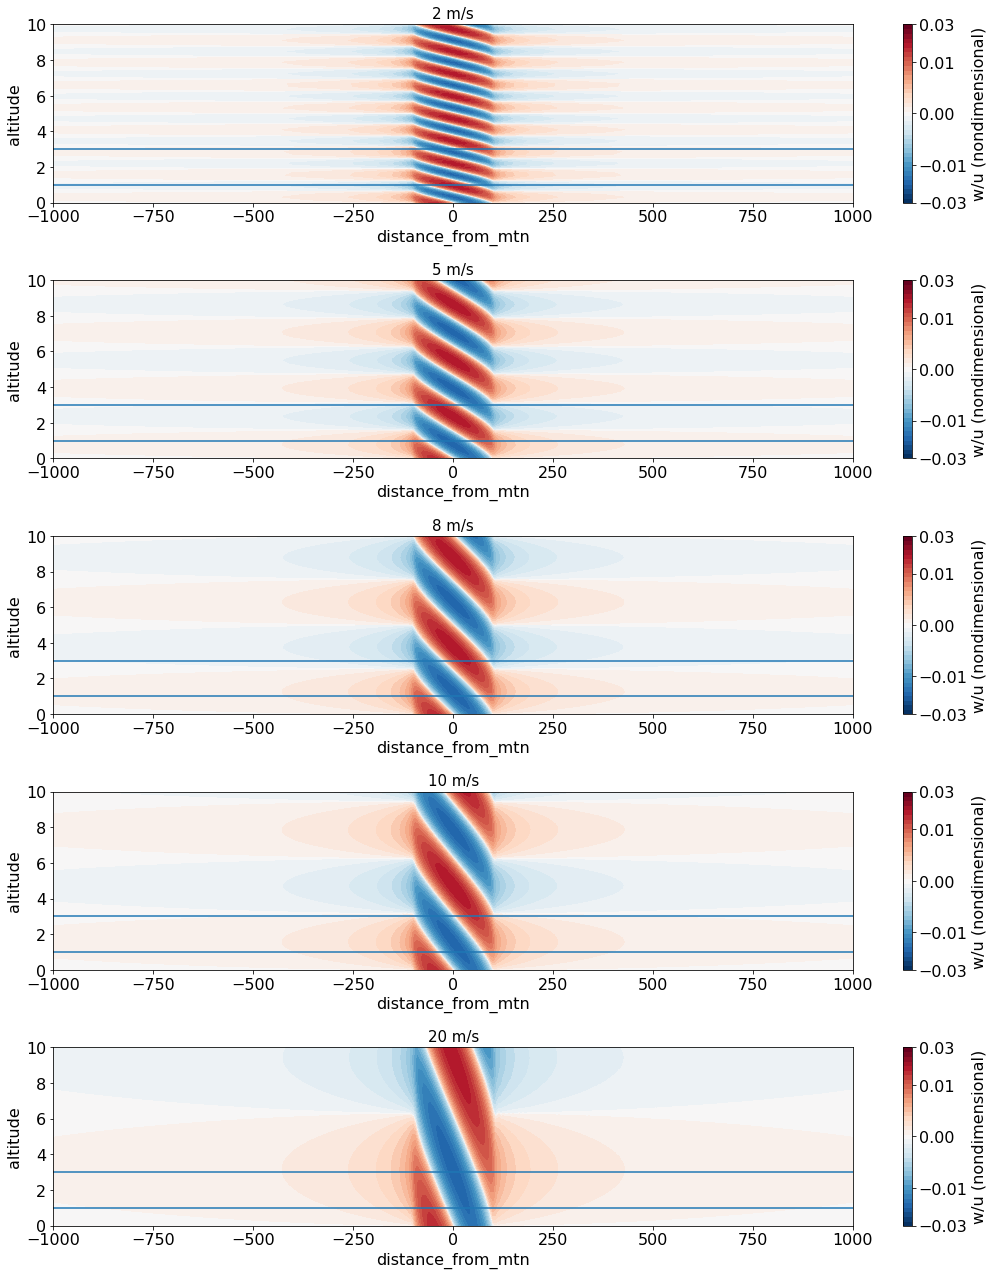

In [106]:
xx,hx=topographic_profile('cos')
fig,ax=plt.subplots(5,1,figsize=(15,18))
for u,a in zip([2,5,8,10,20],ax):
    a.axhline(1)
    a.axhline(3)
    (linear_w_N(x,hx,u,0.01)/u).plot.contourf(ax=a,y='altitude',levels=wlevs,cbar_kwargs={'ticks':wticks,'label':'w/u (nondimensional)'})
    a.set_title("%i m/s"%u,fontsize=15)
    a.set_xlim(-1000,1000)
    a.set_ylim(0,10)
fig.tight_layout()

## 1000 m runs

### Precipitation

In [8]:
#%time hrchannelprecip[200:].mean('south_north').std('Time').to_netcdf('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.precip.std.days50-200.nc')
#%time hrchannel11precip[200:].mean('south_north').std('Time').to_netcdf('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.11mps.3km/diags/wrf.precip.std.days50-150.nc')
hr10std = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.precip.std.days50-200.nc')
hr11std  = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.11mps.3km/diags/wrf.precip.std.days50-150.nc')
hr10pr =  hrchannelprecip[200:].mean(['south_north','Time']).load()
hr11pr  =hrchannel11precip[200:].mean(['south_north','Time']).load()


(-1000.0, 1000.0)

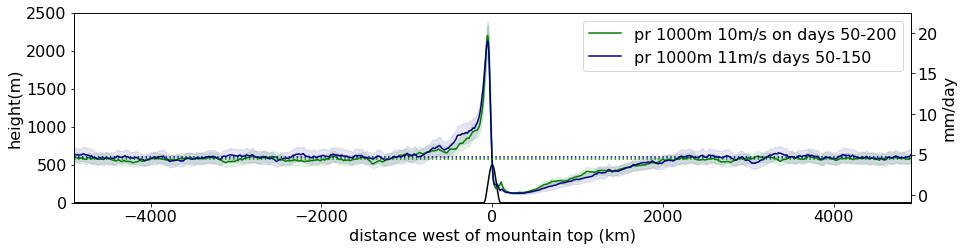

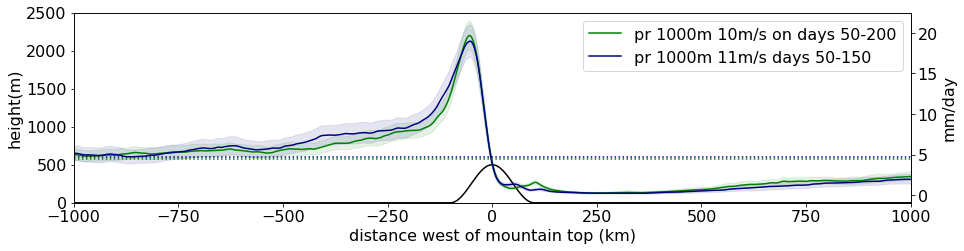

In [11]:
matplotlib.rcParams.update({'font.size':16})

for _ in range(2):
    ax,ax2=plotsection(hrhgt/2,figsize=(15,3.5))
    
    ax2.plot(hrdist,hr10pr,color='g',label='pr 1000m 10m/s on days 50-200')
    ax2.plot(hrdist,hr11pr,color='navy',label='pr 1000m 11m/s days 50-150')
    
    ax2.fill_between(hrdist,hr10pr-2*hr10std/np.sqrt(4*150),hr10pr+2*hr10std/np.sqrt(4*150),alpha=0.1,color='g')
    ax2.fill_between(hrdist,hr11pr-2*hr11std/np.sqrt(4*100),hr11pr+2*hr11std/np.sqrt(4*100),alpha=0.1,color='navy')
    
    ax2.axhline(hr10pr[2200:3000].mean(),color='g',linestyle=':')
    ax2.axhline(hr11pr[2200:3000].mean(),color='navy',linestyle=':')
        
    ax2.set_ylabel("mm/day")
    ax2.legend()
    ax.set_xlim(-4900,4900)
    ax.set_ylim(0.,2500.)
ax.set_xlim(-1000,1000)


In [25]:
peakprecip10 = hrchannelprecip[200:,:,1651:1656]
peakprecip11 = hrchannel11precip[200:,:,1651:1656]
upstreamprecip10 = hrchannelprecip[200:,:,2200:3000].mean()
upstreamprecip11 = hrchannel11precip[200:,:,2200:3000].mean()


print("Peak precip:", end=' '); ratio_CI(peakprecip10,peakprecip11,'(m/s)')
print("Peak P':    ", end=' '); ratio_CI(peakprecip10-upstreamprecip10,peakprecip11-upstreamprecip11,'(m/s)')

Peak precip: Change is -3.3 %/(m/s) (95% CI = [-16.7 to 10.0])
Peak P':     Change is -5.7 %/(m/s) (95% CI = [-22.9 to 11.4])


### T,q

In [16]:
tmean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.T_PL.days50-200.nc')
tmean   = tmean.where(tmean >100.)  
tmean_p = change_coords_pl(hrchannel_p,tmean)[5:-4]

qmean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.Q_PL.days50-200.nc')
qmean = qmean.where(qmean >0.)  
qmean_p = change_coords_pl(hrchannel_p,qmean)[5:-4]

tmean11   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.11mps.3km/diags/wrf.T_PL.days50-110.nc')
tmean11   = tmean11.where(tmean11 >100.)  
tmean11_p = change_coords_pl(lmchannel_11_300p,tmean11)[4:]

qmean11   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.11mps.3km/diags/wrf.Q_PL.days50-110.nc')
qmean11   = qmean11.where(qmean11 >0.)  
qmean11_p = change_coords_pl(lmchannel_11_300p,qmean11)[4:]


In [17]:
tmean_p_hat_prime        = hatprime(tmean_p,0,7)
tmean11_p_hat_prime      = hatprime(tmean11_p,0,7)

qmean_p_hat_prime        = Lc/cp*hatprime(qmean_p,0,7)   # convert to K
qmean11_p_hat_prime      = Lc/cp*hatprime(qmean11_p,0,7) # convert to K

xx,hx = topographic_profile(kind='cos',a=100e3,A=1000)
Td_hat_linear,qd_hat_linear = linear_TdL_qdL(xx,hx,10) 
Td_hat_linear11,qd_hat_linear11 = linear_TdL_qdL(xx,hx,11) 

In [18]:
def linear_q_theory_N(xx,hx,U,N,qfact=1,tauT=3,tauq=11,P0=4.,Td_effect=1,m_effect=1):
    pT_ov_g = 8e3 #mass of troposphere in kg/m2
    
    z=np.arange(0,10000,100)
    k=k_vector(len(xx),xx[1]-xx[0])
    
    tauT*=3600
    tauq*=3600
    
    Lq=compute_Lq(5,U,tauq)
    
    _,dq0dz,_ = lapse_rates()
    N0=0.01
    if Td_effect:
        ds0dz = cp*300/g*N**2
    else:
        ds0dz = cp*300/g*N0**2
    chi = pT_ov_g * (ds0dz/tauT - qfact*dq0dz/tauq)/ Lc * 86400
    
    if not m_effect:
        N=N0
    
    zbot=1000
    ztop=3000    
    z_slice = z[np.where((z>=zbot) & (z<=ztop))]
    relGMS=1/5
    Pprimehat_ov_ik = 1/(1j*k + 1/Lq) * chi * np.fft.fft(hx) * np.exp( m_exponent(k[:,None],N,U)  *  z_slice[None,:]).mean(axis=1) 
    #The relation below comes from u_0d<q_m>/dx+g/PT*M/Ms*P' = 0, then converting to qmL and taking care of units
    qmhat = -Lc/86400 * 1/0.6 * relGMS/pT_ov_g*1/U * Pprimehat_ov_ik
    qdhat = -dq0dz*np.fft.fft(hx)*np.exp( m_exponent(k[:,None],N,U)  *  z_slice[None,:]).mean(axis=1)
    q = np.real(np.fft.ifft(qmhat+qdhat))
    return q/cp
qprime_hat_linear = linear_q_theory_N(xx,hx,10,0.01,qfact=1,tauT=7.5,tauq=27.5)
qprime_hat_linear11 = linear_q_theory_N(xx,hx,11,0.01,qfact=1,tauT=7.5,tauq=27.5)



increase in max, linear theory: T = 19.3%,  q = 22.8%
increase in max, WRF: T = 13.1%,  q = 11.8%


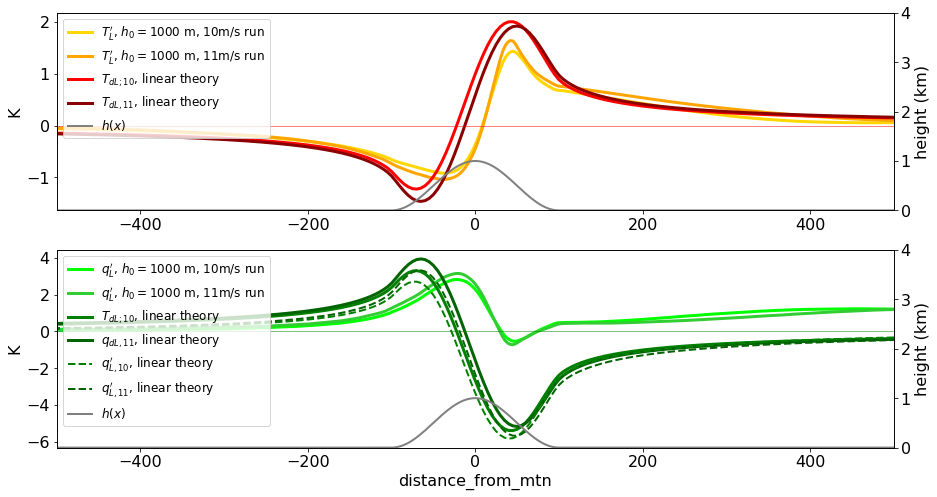

In [129]:
fig,(ax,ax2) = plt.subplots(2,1,figsize=(15,8))
axm=ax.twinx()
ax2m=ax2.twinx()

# Panel a : temperature deviations
tmean_p_hat_prime.plot(  ax=ax,color='gold'  ,linewidth=3,label=r"$T_L'$, $h_0=1000$ m, 10m/s run")
tmean11_p_hat_prime.plot(ax=ax,color='orange',linewidth=3,label=r"$T_L'$, $h_0=1000$ m, 11m/s run")
ax.plot(xx/1000,Td_hat_linear,   color='red'    ,linewidth=3,label=r"$T_{dL;10}$, linear theory")
ax.plot(xx/1000,Td_hat_linear11, color='darkred',linewidth=3,label=r"$T_{dL,11}$, linear theory")
ax.axhline(0.,linestyle='-',linewidth='0.5',color='red')

# Panel b : moisture deviations
qmean_p_hat_prime.plot(  ax=ax2,color='lime'     ,linewidth=3,label=r"$q_L'$, $h_0=1000$ m, 10m/s run")
qmean11_p_hat_prime.plot(ax=ax2,color='limegreen',linewidth=3,label=r"$q_L'$, $h_0=1000$ m, 11m/s run")
ax2.plot(xx/1000,qd_hat_linear,   color='green'    ,linewidth=3,label=r"$T_{dL;10}$, linear theory")
ax2.plot(xx/1000,qd_hat_linear11, color='darkgreen',linewidth=3,label=r"$q_{dL,11}$, linear theory")

ax2.plot(xx/1000,qprime_hat_linear  , color='green'    ,linestyle='--',linewidth=2,label=r"$q_{L,10}'$, linear theory")
ax2.plot(xx/1000,qprime_hat_linear11, color='darkgreen',linestyle='--',linewidth=2,label=r"$q_{L,11}'$, linear theory")

ax2.axhline(0.,linestyle='-',linewidth='0.5',color='green')


for a,am in (ax,axm),(ax2,ax2m):
    a.set_xlim(-500,500)
    a.set_ylabel("K")
    a.legend(fontsize=20)
    
    am.plot(hrdist,hrhgt/1000,label=r"$h(x)$",color='gray',linewidth=2)
    am.set_ylabel('height (km)')
    am.set_ylim(0,4)
    
    lines, labels = a.get_legend_handles_labels()
    lines2, labels2 = am.get_legend_handles_labels()
    a.legend(lines + lines2, labels + labels2,fontsize=12,loc=2)

ax.set_xlabel('')
print("increase in max, linear theory: T = %.1f%%,  q = %.1f%%"%(100*(Td_hat_linear11.min()/Td_hat_linear.min()-1),100*(qprime_hat_linear11.max()/qprime_hat_linear.max()-1)))
print("increase in max, WRF: T = %.1f%%,  q = %.1f%%"%(100*(tmean11_p_hat_prime.min()/tmean_p_hat_prime.min()-1),100*(qmean11_p_hat_prime.max()/qmean_p_hat_prime.max()-1)))

## 500m runs

### Precipitation

In [46]:
#%time lmchannel_11_300precip[200:].mean('south_north').std('Time').to_netcdf('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.11mps.3km/diags/wrf.precip.std.days50-400.nc')
#%time lmchannel_9_300precip[200:].mean('south_north').std('Time').to_netcdf('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.9mps.3km/diags/wrf.precip.std.days50-400.nc')
lm11_300std = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.11mps.3km/diags/wrf.precip.std.days50-400.nc')
lm9_300std  = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.9mps.3km/diags/wrf.precip.std.days50-400.nc')
lm11_300pr = lmchannel_11_300precip[200:].mean(['Time','south_north'])
lm9_300pr  = lmchannel_9_300precip[200:].mean(['Time','south_north'])

In [47]:
xx,hx = topographic_profile('cos',A=500)
Plin_9 = linear_precip_theory(xx,hx,9,7.5,27.5)
Plin_11 = linear_precip_theory(xx,hx,11,7.5,27.5)

In [54]:
xx,hx = topographic_profile('cos',A=500)
Plin_9_2  = linear_precip_theory_N(xx,hx,9 ,0.012,tauT=7.5,tauq=27.5)
Plin_11_2 = linear_precip_theory_N(xx,hx,11,0.012,tauT=7.5,tauq=27.5)

(-1500.0, 1500.0)

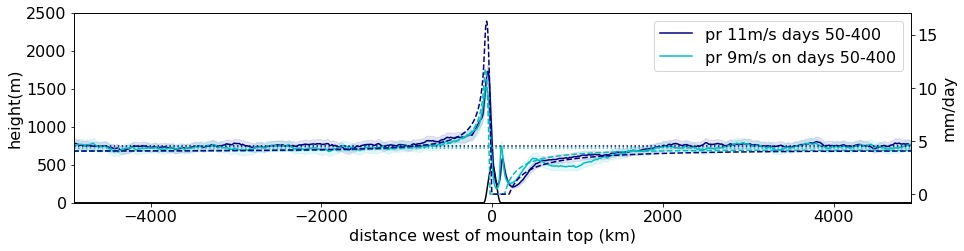

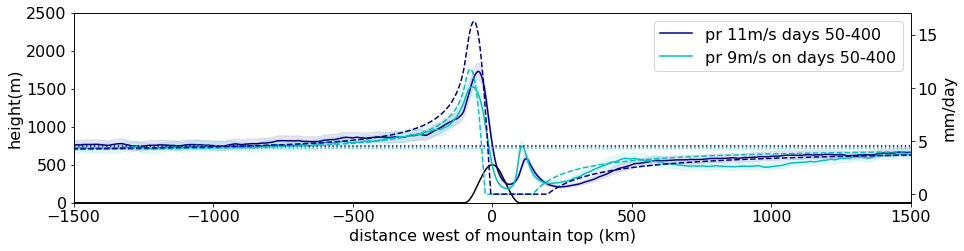

In [65]:
matplotlib.rcParams.update({'font.size':16})
for _ in range(2):
    ax,ax2=plotsection(hrhgt/2,figsize=(15,3.5))
    
    ax2.plot(hrdist,lm11_300pr,color='navy',label='pr 11m/s days 50-400')
    ax2.plot(hrdist,lm9_300pr,color='c',label='pr 9m/s on days 50-400')
    
    ax2.fill_between(hrdist,lm11_300pr-2*lm11_300std/np.sqrt(4*350),lm11_300pr+2*lm11_300std/np.sqrt(4*350),alpha=0.1,color='navy')
    ax2.fill_between(hrdist,lm9_300pr-2*lm9_300std/np.sqrt(4*350),lm9_300pr+2*lm9_300std/np.sqrt(4*350),alpha=0.1,color='c')
    
    ax2.axhline(lm11_300pr[2200:3000].mean(),color='navy',linestyle=':')
    ax2.axhline(lm9_300pr[2200:3000].mean(),color='c'  ,linestyle=':')
    
    ax2.plot(xx/1000,Plin_9,color='c',linestyle='--')
    ax2.plot(xx/1000,Plin_11,color='navy',linestyle='--')
    #ax2.plot(xx/1000,Plin_9_2,color='c',linestyle=':')
    #ax2.plot(xx/1000,Plin_11_2,color='navy',linestyle=':')
        
    ax2.set_ylabel("mm/day")
    ax2.legend()
    ax.set_xlim(-4900,4900)
    ax.set_ylim(0.,2500.)
ax.set_xlim(-1500,1500)

In [28]:
peakpreciplm_9_300  = lmchannel_9_300precip[200:,:,1657:1662]
peakpreciplm_11_300 = lmchannel_11_300precip[200:,:,1650:1655]
upstreampreciplm_9_300  = lmchannel_9_300precip[200:,:,2200:3000].mean()
upstreampreciplm_11_300 = lmchannel_11_300precip[200:,:,2200:3000].mean()
print("Peak precip:", end=' '); ratio_CI(peakpreciplm_9_300,peakpreciplm_11_300,'(m/s)',norm=2)
print("Peak P':    ", end=' '); ratio_CI(peakpreciplm_9_300-upstreampreciplm_9_300,peakpreciplm_11_300-upstreampreciplm_11_300,'(m/s)',norm=2)

Peak precip: Change is 7.1 %/(m/s) (95% CI = [1.1 to 13.0])
Peak P':     Change is 10.9 %/(m/s) (95% CI = [0.0 to 21.9])


In [37]:
print("Theoretical change in peak precip: %.1f %%/(m/s)"%(100*(np.max(Plin_11)/np.max(Plin_9)-1)/2))

Theoretical change in peak precip: 19.2 %/(m/s)


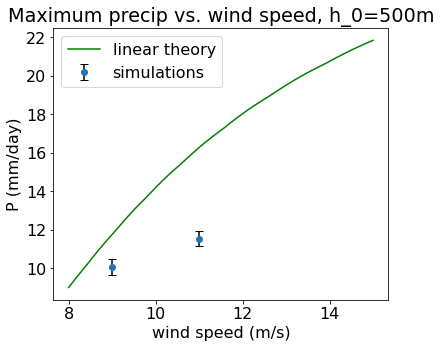

In [59]:
u_array=np.linspace(8,15)
xx,hx = topographic_profile('cos',A=500)
Pmax_array=[np.max(linear_precip_theory(xx,hx,u,7.5,27.5)) for u in u_array]
_,ax=plt.subplots(1,1,figsize=(6,5))
ax.plot(u_array,Pmax_array,color='g',label='linear theory')
ax.set_xlabel('wind speed (m/s)')
ax.set_ylabel('P (mm/day)')
ax.set_title("Maximum precip vs. wind speed, h_0=500m")
ax.errorbar([9,11],[np.max(lm9_300pr),np.max(lm11_300pr)],yerr=[lm9_300std[np.argmax(np.array(lm9_300pr))]/np.sqrt(4*350),lm11_300std[np.argmax(np.array(lm11_300pr))]/np.sqrt(4*350)],fmt='o',ecolor='k',capsize=4,label='simulations')
ax.legend()

### T,q,w

In [15]:
%time lmchannel_9_300p.Q_PL[1200:].mean(['Time','south_north']).to_netcdf('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.9mps.3km/diags/wrf.Q_PL.days50-400.nc')

CPU times: user 4min 9s, sys: 18min 38s, total: 22min 47s
Wall time: 16min 35s


In [68]:
lmtmean_9_300   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.9mps.3km/diags/wrf.T_PL.days50-400.nc')
lmtmean_9_300   = lmtmean_9_300.where(lmtmean_9_300 >100.)  
lmtmean_9_300_p = change_coords_pl(lmchannel_9_300p,lmtmean_9_300)

lmqmean_9_300   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.9mps.3km/diags/wrf.Q_PL.days50-400.nc')
lmqmean_9_300   = lmqmean_9_300.where(lmqmean_9_300 >0.)  
lmqmean_9_300_p = change_coords_pl(lmchannel_9_300p,lmqmean_9_300)

lmtmean_11_300   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.11mps.3km/diags/wrf.T_PL.days50-400.nc')
lmtmean_11_300   = lmtmean_11_300.where(lmtmean_11_300 >100.)  
lmtmean_11_300_p = change_coords_pl(lmchannel_11_300p,lmtmean_11_300)

lmqmean_11_300   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.11mps.3km/diags/wrf.Q_PL.days50-400.nc')
lmqmean_11_300   = lmqmean_11_300.where(lmqmean_11_300 >0.)  
lmqmean_11_300_p = change_coords_pl(lmchannel_11_300p,lmqmean_11_300)


In [69]:
lmtmean_9_300_p_hat_prime  = hatprime(lmtmean_9_300_p,4,11)
lmtmean_11_300_p_hat_prime = hatprime(lmtmean_11_300_p,4,11)

lmqmean_9_300_p_hat_prime  = Lc/cp*hatprime(lmqmean_9_300_p,4,11)  # convert to K
lmqmean_11_300_p_hat_prime = Lc/cp*hatprime(lmqmean_11_300_p,4,11) # convert to K

xx,hx = topographic_profile(kind='cos',a=100e3,A=500)
lmTd_hat_linear9, lmqd_hat_linear9 = linear_TdL_qdL(xx,hx,9) 
lmTd_hat_linear11,lmqd_hat_linear11 = linear_TdL_qdL(xx,hx,11) 

increase in max, linear theory: T = 27.7%/(m/s),  q = 27.7%/(m/s)
increase in max, WRF: T = 18.4%/(m/s),  q = 12.8%/(m/s)


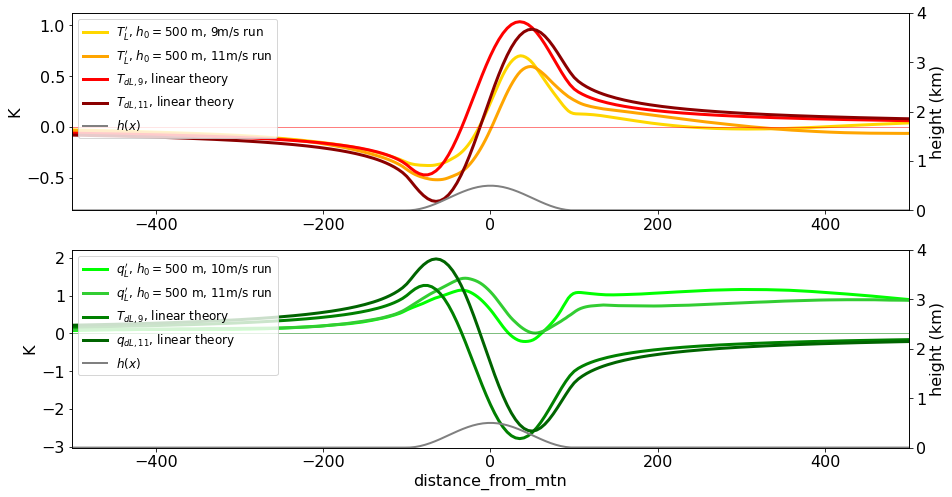

In [70]:
fig,(ax,ax2) = plt.subplots(2,1,figsize=(15,8))
axm=ax.twinx()
ax2m=ax2.twinx()

# Panel a : temperature deviations
lmtmean_9_300_p_hat_prime.plot( ax=ax,color='gold'  ,linewidth=3,label=r"$T_L'$, $h_0=500$ m, 9m/s run")
lmtmean_11_300_p_hat_prime.plot(ax=ax,color='orange',linewidth=3,label=r"$T_L'$, $h_0=500$ m, 11m/s run")
ax.plot(xx/1000,lmTd_hat_linear9,   color='red'    ,linewidth=3,label=r"$T_{dL,9}$, linear theory")
ax.plot(xx/1000,lmTd_hat_linear11,   color='darkred',linewidth=3,label=r"$T_{dL,11}$, linear theory")
ax.axhline(0.,linestyle='-',linewidth='0.5',color='red')

# Panel b : moisture deviations
lmqmean_9_300_p_hat_prime.plot( ax=ax2,color='lime'     ,linewidth=3,label=r"$q_L'$, $h_0=500$ m, 10m/s run")
lmqmean_11_300_p_hat_prime.plot(ax=ax2,color='limegreen',linewidth=3,label=r"$q_L'$, $h_0=500$ m, 11m/s run")
ax2.plot(xx/1000,lmqd_hat_linear9,   color='green'    ,linewidth=3,label=r"$T_{dL,9}$, linear theory")
ax2.plot(xx/1000,lmqd_hat_linear11,   color='darkgreen',linewidth=3,label=r"$q_{dL,11}$, linear theory")
ax2.axhline(0.,linestyle='-',linewidth='0.5',color='green')


for a,am in (ax,axm),(ax2,ax2m):
    a.set_xlim(-500,500)
    a.set_ylabel("K")
    a.legend(fontsize=20)
    
    am.plot(hrdist,hrhgt/2000,label=r"$h(x)$",color='gray',linewidth=2)
    am.set_ylabel('height (km)')
    am.set_ylim(0,4)
    
    lines, labels = a.get_legend_handles_labels()
    lines2, labels2 = am.get_legend_handles_labels()
    a.legend(lines + lines2, labels + labels2,fontsize=12,loc=2)

ax.set_xlabel('')
print("increase in max, linear theory: T = %.1f%%/(m/s),  q = %.1f%%/(m/s)"%(100*(lmTd_hat_linear11.min()/lmTd_hat_linear9.min()-1)/2,100*(lmqd_hat_linear11.max()/lmqd_hat_linear9.max()-1)/2))
print("increase in max, WRF: T = %.1f%%/(m/s),  q = %.1f%%/(m/s)"%(100*(lmtmean_11_300_p_hat_prime.min()/lmtmean_9_300_p_hat_prime.min()-1)/2,100*(lmqmean_11_300_p_hat_prime.max()/lmqmean_9_300_p_hat_prime.max()-1)/2))


In [173]:
lmwmean_9_300_s  = change_coords_eta(lmbegin_9_300,xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.9mps.3km/diags/wrf.W.days50-400.nc'),staggered=True)
lmwmean_11_300_s = change_coords_eta(lmbegin_9_300,xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.11mps.3km/diags/wrf.W.days50-400.nc'),staggered=True)
lmwmean_9_300_p  = interp_eta_to_pressure(lmbegin_9_300,lmwmean_9_300_s )
lmwmean_11_300_p = interp_eta_to_pressure(lmbegin_9_300,lmwmean_11_300_s)

xx,hx = topographic_profile(kind='cos',a=100e3,A=500)
linear_w_9  = linear_w_N(xx,hx,9 ,0.012,vert_coord='p') 
linear_w_11 = linear_w_N(xx,hx,11,0.012,vert_coord='p')


(-0.07, 0.07)

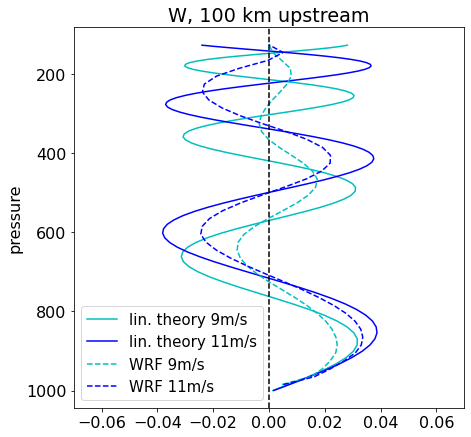

In [174]:
_,ax=plt.subplots(1,1,figsize=(7,7))

linear_w_9   .sel(distance_from_mtn=-100,method='nearest').plot(ax=ax,y='pressure',yincrease=False,color='c',label='lin. theory 9m/s')
linear_w_11  .sel(distance_from_mtn=-100,method='nearest').plot(ax=ax,y='pressure',yincrease=False,color='b',label='lin. theory 11m/s')
lmwmean_9_300_p .sel(distance_from_mtn=-100,method='nearest').plot(ax=ax,y='pressure',yincrease=False,color='c',linestyle='--',label='WRF 9m/s')
lmwmean_11_300_p.sel(distance_from_mtn=-100,method='nearest').plot(ax=ax,y='pressure',yincrease=False,color='b',linestyle='--',label='WRF 11m/s')
ax.axvline(0.,color='k',linestyle='--')
ax.set_title("W, 100 km upstream")
ax.legend(fontsize=15)
ax.set_xlim(-0.07,0.07)

(0.005, 0.015)

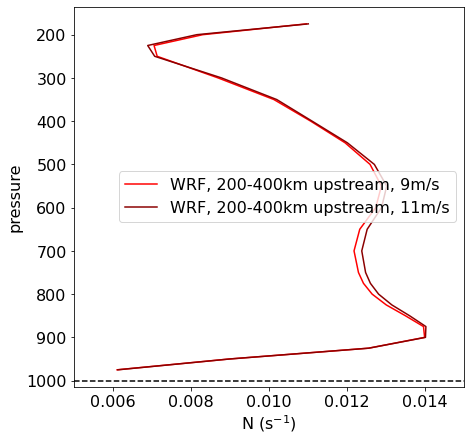

In [73]:
fig,ax = plt.subplots(1,1,figsize=(7,7))
compute_N(lmtmean_9_300_p .sel(distance_from_mtn=slice(-200,-400)).mean('distance_from_mtn'),100).plot(ax=ax,y='pressure',yincrease=False,color='red'    ,label='WRF, 200-400km upstream, 9m/s')
compute_N(lmtmean_11_300_p.sel(distance_from_mtn=slice(-200,-400)).mean('distance_from_mtn'),100).plot(ax=ax,y='pressure',yincrease=False,color='darkred',label='WRF, 200-400km upstream, 11m/s')

ax.set_xlabel(r"N (s$^{-1})$")
ax.axvline(0.,color='k',linestyle='--')
ax.axhline(1000.,color='k',linestyle='--')
ax.legend()
ax.set_xlim(0.005,0.015)

# Thermodynamic sensitivity

## Theory

In [90]:
def sensitivity(N0,u0,param):
    """Unit sensitivity (% change in max precip per percent change in input param)"""
    x,hx = topographic_profile(kind='cos')
    Plin   = linear_precip_theory_N(x,hx,u0,N0,tauT=7.5,tauq=27.5,P0 = 4.)-4.
    if param=='N':
        Plin_m = linear_precip_theory_N(x,hx,u0,N0*0.99,tauT=7.5,tauq=27.5,P0 = 4.)-4.
        Plin_p = linear_precip_theory_N(x,hx,u0,N0*1.01,tauT=7.5,tauq=27.5,P0 = 4.)-4.
    elif param=='u':
        Plin_m = linear_precip_theory_N(x,hx,u0*0.99,N0,tauT=7.5,tauq=27.5,P0 = 4.)-4.
        Plin_p = linear_precip_theory_N(x,hx,u0*1.01,N0,tauT=7.5,tauq=27.5,P0 = 4.)-4.
    elif param=='q':
        Plin_m = linear_precip_theory_N(x,hx,u0,N0,qfact=0.99,tauT=7.5,tauq=27.5,P0 = 4.)-4.
        Plin_p = linear_precip_theory_N(x,hx,u0,N0,qfact=1.01,tauT=7.5,tauq=27.5,P0 = 4.)-4.
    else:
        raise ValueError('Param must be N,u or q')
    return (Plin_p.max()-Plin_m.max())/Plin.max() / 0.02
sensitivity = np.vectorize(sensitivity)

In [91]:
N_=np.linspace(1e-2,1.4e-2,20)
u_=np.linspace(8,12,20)
uu,NN = np.meshgrid(u_,N_)
sensitivitiesN = sensitivity(NN,uu,'N')
sensitivitiesu = sensitivity(NN,uu,'u')
sensitivitiesq = sensitivity(NN,uu,'q')

Below, we plot unit sensitivities of the maximum P' to three parameters, i.e. $S_\mathrm{param} = \dfrac{\mathrm{d}\ln(\max P')}{\mathrm{d}\ln \mathrm{param}}$ (for a x % increase in the parameter, what is the percent increase in max P' ?).

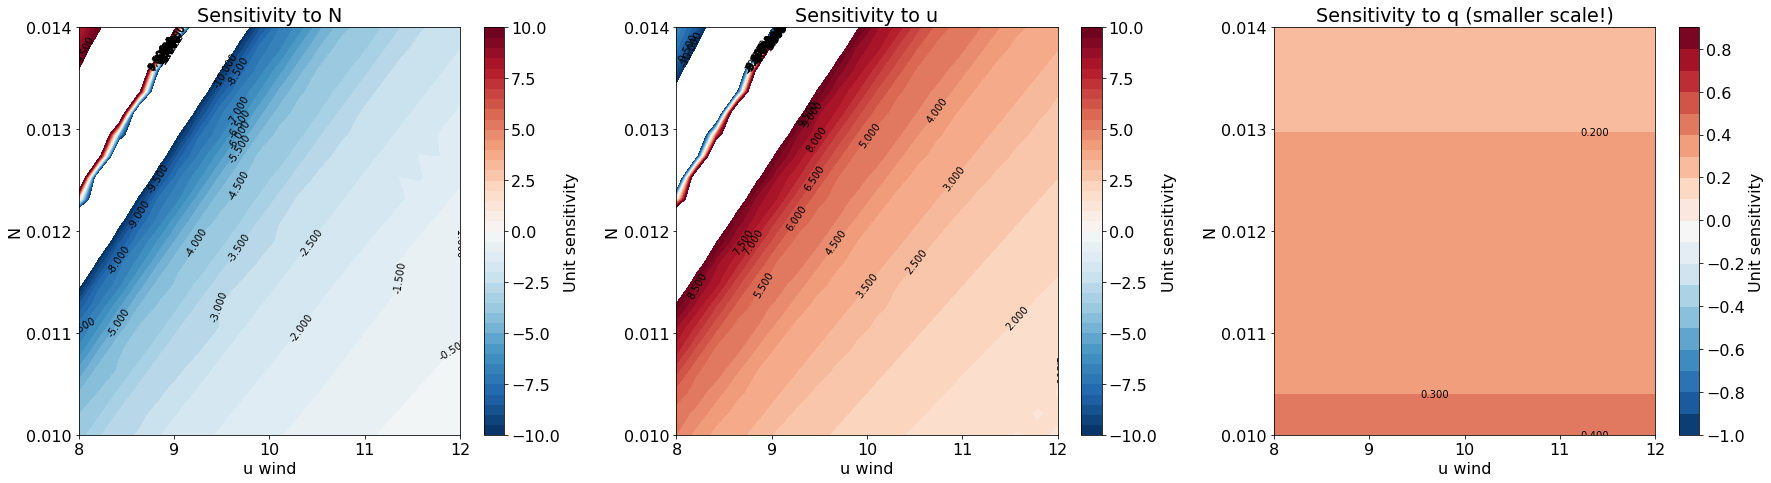

In [94]:
fig,axs=plt.subplots(1,3,figsize=(25,7))
for ax,sens,ttl,lvls in zip(axs,(sensitivitiesN,sensitivitiesu,sensitivitiesq),('N','u','q (smaller scale!)'),(np.arange(-10,10.5,0.5),np.arange(-10,10.5,0.5),np.arange(-1,1,0.1))):
    cf=ax.contourf(uu,NN,sens,cmap=plt.cm.RdBu_r,levels = lvls)
    fig.colorbar(cf,ax=ax,label='Unit sensitivity')
    cf.clabel(colors='k',fontsize=10,inline=False)
    ax.set_xlabel('u wind')
    ax.set_ylabel('N')
    ax.set_title("Sensitivity to "+ttl)
    ax.set_yticks(np.arange(0.01,0.015,0.001))
fig.tight_layout()

## Applying the theory with changes from CMIP6

With a base state $u_0 = 10$ m/s and $N=0.012$ s$^{-1}$ (and dq/dz = 3.2 g/kg/km as in our paper, but this is less important), the above sensitivities are:
$S_N = -2.5$, $S_u=3.9$, $S_q = 0.3$.

We take average CMIP6 changes for the Western Ghats: u increases at 0.2 m/s/K, N at $10^{-4}$ s$^{-1}$/K and q at 7%/K (following CC scaling).


In [106]:
sensu = 3.9;sensN=-2.5;sensq=0.3
print("Hence, u decreases by 2%%/K, N increases by 1%%/K and q by 7%%/K so -2*%.2f + 1*(%.2f) + 7*(%.2f) = %.2f %%/K (change in max P')"%(sensu,sensN,sensq,-2*sensu+sensN+7*sensq))
print('Note that this will be partly offset by an increase in mean P')

Hence, u decreases by 2%/K, N increases by 1%/K and q by 7%/K so -2*3.90 + 1*(-2.50) + 7*(0.30) = -8.20 %/K (change in max P')
Note that this will be partly offset by an increase in mean P


Decrease in max P': -8.36 %/K
Decrease in max P (with background P increase at CC rate): -5.08 %/K


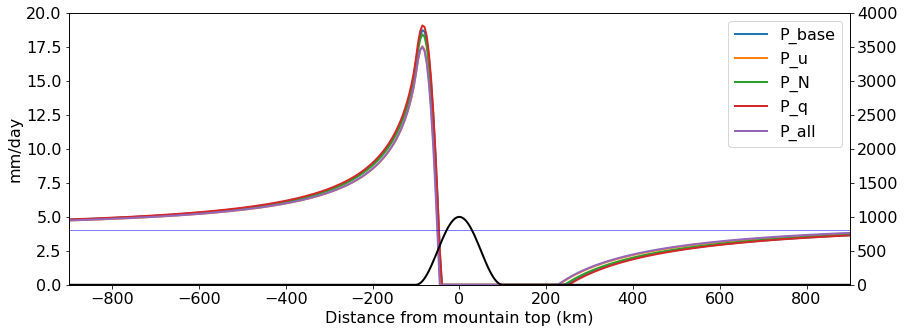

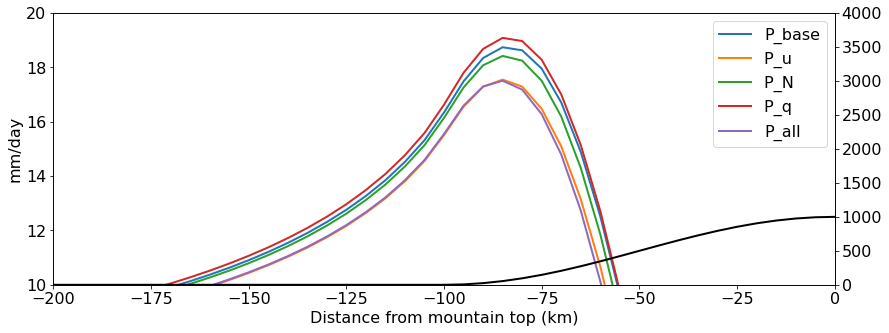

In [110]:
lw=2

u_base = 10
dudT = -0.2 # m/s/K
N_base = 0.012
dNdT = 1e-4 # s^-1/K
dlnqdT = 7e-2 # 1/K

x,hx = topographic_profile(kind='cos')
Plin = linear_precip_theory_N(x,hx,u_base,N_base,qfact=1,tauT=7.5,tauq=27.5,P0=4.)
P_u  = linear_precip_theory_N(x,hx,u_base+dudT,N_base,qfact=1,tauT=7.5,tauq=27.5,P0=4.)
P_N  = linear_precip_theory_N(x,hx,u_base,N_base+dNdT,qfact=1,tauT=7.5,tauq=27.5,P0=4.)
P_q  = linear_precip_theory_N(x,hx,u_base,N_base,qfact=1+dlnqdT,tauT=7.5,tauq=27.5,P0=4.)
P_all= linear_precip_theory_N(x,hx,u_base+dudT,N_base+dNdT,qfact=1+dlnqdT,tauT=7.5,tauq=27.5,P0=4.)

for _ in range(2):
    fig,ax=plt.subplots(1,1,figsize=(14,5))
    ax2=ax.twinx()
    ax.plot(x/1000,Plin,label = "P_base",linewidth=lw)
    ax.plot(x/1000,P_u  ,label = "P_u  ",linewidth=lw)
    ax.plot(x/1000,P_N  ,label = "P_N  ",linewidth=lw)
    ax.plot(x/1000,P_q  ,label = "P_q  ",linewidth=lw)
    ax.plot(x/1000,P_all,label = "P_all",linewidth=lw)
    # mountain
    ax2.plot(x/1000,hx,label=r"$h(x)$",color='k',linewidth=2)
    
    ax.axhline(4.,linestyle='-',linewidth=0.5,color='b')
    ax.set_xlabel('Distance from mountain top (km)')
    ax.set_ylabel('mm/day')
    ax.set_xlim(-900,900)
    ax.set_ylim(0,20)
    ax2.set_ylim(0,4000)
    ax.legend()
ax.set_ylim(10,20)
ax.set_xlim(-200,0)
print("Decrease in max P': %.2f %%/K"%(((P_all.max()-4)/(Plin.max()-4)-1)*100))
P_all_2= linear_precip_theory_N(x,hx,u_base+dudT,N_base+dNdT,qfact=1+dlnqdT,tauT=7.5,tauq=27.5,P0=4.*1.07)
print("Decrease in max P (with background P increase at CC rate): %.2f %%/K"%(((P_all_2.max())/(Plin.max())-1)*100))


## 500 m runs - 11m/s - 298K & 302K

In [62]:
lmtmean_11_298   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.11mps.298K.3km/diags/wrf.T_PL.days50-600.nc')
lmtmean_11_298   = lmtmean_11_298.where(lmtmean_11_298 >100.)  
lmtmean_11_298_p = change_coords_pl(lmchannel_11_298p,lmtmean_11_298)

lmqmean_11_298   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.11mps.298K.3km/diags/wrf.Q_PL.days50-600.nc')
lmqmean_11_298   = lmqmean_11_298.where(lmqmean_11_298 >0.)  
lmqmean_11_298_p = change_coords_pl(lmchannel_11_298p,lmqmean_11_298)

lmtmean_11_302   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.11mps.302K.3km/diags/wrf.T_PL.days50-600.nc')
lmtmean_11_302   = lmtmean_11_302.where(lmtmean_11_302 >100.)  
lmtmean_11_302_p = change_coords_pl(lmchannel_11_302p,lmtmean_11_302)

lmqmean_11_302   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.11mps.302K.3km/diags/wrf.Q_PL.days50-600.nc')
lmqmean_11_302   = lmqmean_11_302.where(lmqmean_11_302 >0.)  
lmqmean_11_302_p = change_coords_pl(lmchannel_11_302p,lmqmean_11_302)


### N,dq/dz

Fractional change (900-700hPa mean): 1.42 %/K


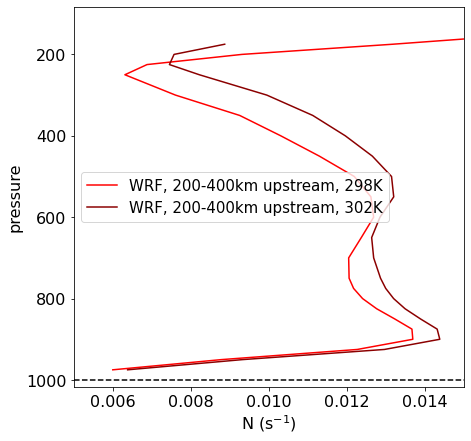

In [123]:
fig,ax = plt.subplots(1,1,figsize=(7,7))
N_298 = compute_N(lmtmean_11_298_p.sel(distance_from_mtn=slice(-200,-400)).mean('distance_from_mtn'),100)
N_302 = compute_N(lmtmean_11_302_p.sel(distance_from_mtn=slice(-200,-400)).mean('distance_from_mtn'),100)
N_298.plot(ax=ax,y='pressure',yincrease=False,color='red'    ,label='WRF, 200-400km upstream, 298K')
N_302.plot(ax=ax,y='pressure',yincrease=False,color='darkred',label='WRF, 200-400km upstream, 302K')

ax.set_xlabel(r"N (s$^{-1})$")
ax.axvline(0.,color='k',linestyle='--')
ax.axhline(1000.,color='k',linestyle='--')
ax.legend(fontsize=15,loc=6)
ax.set_xlim(0.005,0.015)

print("Fractional change (900-700hPa mean): %.2f %%/K"%((N_302.sel(pressure=slice(900,700)).mean()/N_298.sel(pressure=slice(900,700)).mean()-1)*100/4))

Fractional change (900-700hPa mean): 9.09 %/K
Fractional change (surface): 7.57 %/K


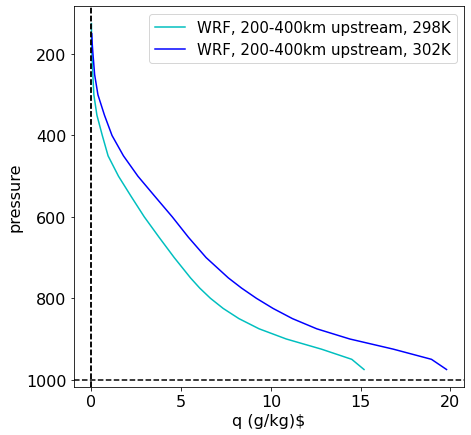

In [131]:
fig,ax = plt.subplots(1,1,figsize=(7,7))
q_298 = lmqmean_11_298_p.sel(distance_from_mtn=slice(-200,-400)).mean('distance_from_mtn')
q_302 = lmqmean_11_302_p.sel(distance_from_mtn=slice(-200,-400)).mean('distance_from_mtn')
(1e3*q_298).plot(ax=ax,y='pressure',yincrease=False,color='c'    ,label='WRF, 200-400km upstream, 298K')
(1e3*q_302).plot(ax=ax,y='pressure',yincrease=False,color='b',label='WRF, 200-400km upstream, 302K')

ax.axvline(0.,color='k',linestyle='--')
ax.set_xlabel(r"q (g/kg)$")
ax.axvline(0.,color='k',linestyle='--')
ax.axhline(1000.,color='k',linestyle='--')
ax.legend(fontsize=15)

print("Fractional change (900-700hPa mean): %.2f %%/K"%((q_302.sel(pressure=slice(900,700)).mean()/q_298.sel(pressure=slice(900,700)).mean()-1)*100/4))
print("Fractional change (surface): %.2f %%/K"%((q_302[0]/q_298[0]-1)*100/4))



### Precipitation

In [137]:
#%time lmchannel_11_298precip[200:].mean('south_north').std('Time').to_netcdf('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.11mps.298K.3km/diags/wrf.precip.std.days50-600.nc')
#%time lmchannel_11_302precip[200:].mean('south_north').std('Time').to_netcdf('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.11mps.302K.3km/diags/wrf.precip.std.days50-600.nc')
lm11_298std = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.11mps.298K.3km/diags/wrf.precip.std.days50-600.nc')
lm11_302std = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.11mps.302K.3km/diags/wrf.precip.std.days50-600.nc')
lm11_298pr = lmchannel_11_298precip[200:].mean(['Time','south_north'])
lm11_302pr = lmchannel_11_302precip[200:].mean(['Time','south_north'])

(-1500.0, 1500.0)

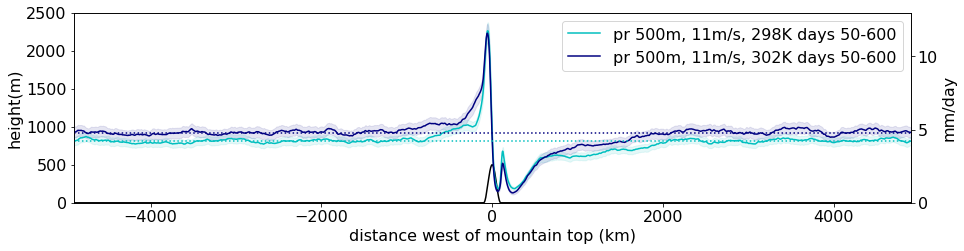

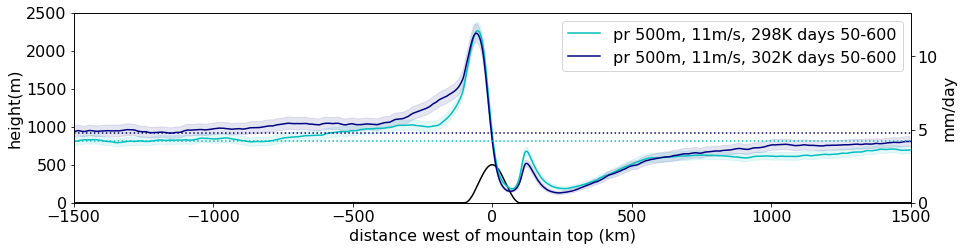

In [164]:
matplotlib.rcParams.update({'font.size':16})
for _ in range(2):
    ax,ax2=plotsection(hrhgt/2,figsize=(15,3.5))
    
    ax2.plot(hrdist,lm11_298pr,color='c'   ,label='pr 500m, 11m/s, 298K days 50-600')
    ax2.plot(hrdist,lm11_302pr,color='navy',label='pr 500m, 11m/s, 302K days 50-600')
    
    
    ax2.fill_between(hrdist,lm11_298pr-2*lm11_298std/np.sqrt(4*550),lm11_298pr+2*lm11_298std/np.sqrt(4*550),alpha=0.1,color='c')
    ax2.fill_between(hrdist,lm11_302pr-2*lm11_302std/np.sqrt(4*550),lm11_302pr+2*lm11_302std/np.sqrt(4*550),alpha=0.1,color='navy')
    
    ax2.axhline(lm11_298pr[2200:3000].mean(),color='c'  ,linestyle=':')
    ax2.axhline(lm11_302pr[2200:3000].mean(),color='navy',linestyle=':')
    
    #ax2.plot(xx/1000,Plin_9,color='c',linestyle='--')
    #ax2.plot(xx/1000,Plin_11,color='navy',linestyle='--')

        
    ax2.set_ylabel("mm/day")
    ax2.legend()
    ax.set_xlim(-4900,4900)
    ax.set_ylim(0.,2500.)
    ax2.set_ylim(0.,13.)
ax.set_xlim(-1500,1500)

In [163]:
peakpreciplm_11_298 = lmchannel_11_298precip[200:,:,1650:1655]
peakpreciplm_11_302 = lmchannel_11_302precip[200:,:,1652:1657]
upstreampreciplm_11_298 = lmchannel_11_298precip[200:,:,2200:3000].mean()
upstreampreciplm_11_302 = lmchannel_11_302precip[200:,:,2200:3000].mean()
print("Peak precip:    ", end=' '); ratio_CI(peakpreciplm_11_298,peakpreciplm_11_302,'K',norm=4)
print("Upstream precip:", end=' '); ratio_CI(lmchannel_11_298precip[200:,:,2200:3000],lmchannel_11_302precip[200:,:,2200:3000],'K',norm=4)
print("Peak P':        ", end=' '); ratio_CI(peakpreciplm_11_298-upstreampreciplm_11_298,peakpreciplm_11_302-upstreampreciplm_11_302,'K',norm=4)



Peak precip:     Change is -0.4 %/K (95% CI = [-2.2 to 1.5])
Upstream precip: Change is 3.6 %/K (95% CI = [3.0 to 4.1])
Peak P':         Change is -2.5 %/K (95% CI = [-5.3 to 0.2])


In [148]:
xx,hx = topographic_profile('cos',A=500)
Pprimelin_298  = linear_precip_theory_N(xx,hx,11,0.012,qfact=1/1.09**2,tauT=7.5,tauq=27.5)-4.
Pprimelin_302  = linear_precip_theory_N(xx,hx,11,0.012*1.014**4,qfact=1.09**2,tauT=7.5,tauq=27.5)-4.

In [149]:
print("Theoretical change in peak P': %.1f %%/K"%(100*(np.max(Pprimelin_302)/np.max(Pprimelin_298)-1)/4))

Theoretical change in peak P': 0.4 %/K


### T,q,w

In [63]:
lmtmean_11_298_p_hat_prime = hatprime(lmtmean_11_298_p,4,11)
lmtmean_11_302_p_hat_prime = hatprime(lmtmean_11_302_p,4,11)

lmqmean_11_298_p_hat_prime = Lc/cp*hatprime(lmqmean_11_298_p,4,11)  # convert to K
lmqmean_11_302_p_hat_prime = Lc/cp*hatprime(lmqmean_11_302_p,4,11) # convert to K

xx,hx = topographic_profile(kind='cos',a=100e3,A=500)
lmTd_hat_linear298,lmqd_hat_linear298 = linear_TdL_qdL_N(xx,hx,11,0.012,qfact=1/1.09**2)
lmTd_hat_linear302,lmqd_hat_linear302 = linear_TdL_qdL_N(xx,hx,11,0.012*1.014**4,qfact=1.09**2)

increase in max, linear theory: T = -1.4%/K,  q = 4.7%/K
increase in max, WRF: T = 2.6%/K,  q = 5.1%/K


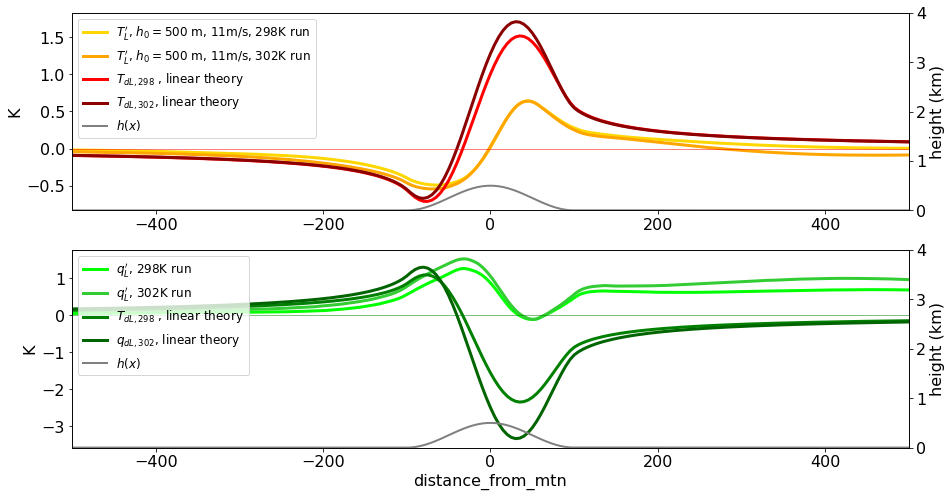

In [168]:
fig,(ax,ax2) = plt.subplots(2,1,figsize=(15,8))
axm=ax.twinx()
ax2m=ax2.twinx()

# Panel a : temperature deviations
lmtmean_11_298_p_hat_prime.plot(ax=ax,color='gold'  ,linewidth=3,label=r"$T_L'$, $h_0=500$ m, 11m/s, 298K run")
lmtmean_11_302_p_hat_prime.plot(ax=ax,color='orange',linewidth=3,label=r"$T_L'$, $h_0=500$ m, 11m/s, 302K run")
ax.plot(xx/1000,lmTd_hat_linear298,   color='red'    ,linewidth=3,label=r"$T_{dL,298}$ , linear theory")
ax.plot(xx/1000,lmTd_hat_linear302,   color='darkred',linewidth=3,label=r"$T_{dL,302}$, linear theory")
ax.axhline(0.,linestyle='-',linewidth='0.5',color='red')

# Panel b : moisture deviations
lmqmean_11_298_p_hat_prime.plot(ax=ax2,color='lime'     ,linewidth=3,label=r"$q_L'$, 298K run")
lmqmean_11_302_p_hat_prime.plot(ax=ax2,color='limegreen',linewidth=3,label=r"$q_L'$, 302K run")
ax2.plot(xx/1000,lmqd_hat_linear298,   color='green'    ,linewidth=3,label=r"$T_{dL,298}$ , linear theory")
ax2.plot(xx/1000,lmqd_hat_linear302,   color='darkgreen',linewidth=3,label=r"$q_{dL,302}$, linear theory")
ax2.axhline(0.,linestyle='-',linewidth='0.5',color='green')


for a,am in (ax,axm),(ax2,ax2m):
    a.set_xlim(-500,500)
    a.set_ylabel("K")
    a.legend(fontsize=20)
    
    am.plot(hrdist,hrhgt/2000,label=r"$h(x)$",color='gray',linewidth=2)
    am.set_ylabel('height (km)')
    am.set_ylim(0,4)
    
    lines, labels = a.get_legend_handles_labels()
    lines2, labels2 = am.get_legend_handles_labels()
    a.legend(lines + lines2, labels + labels2,fontsize=12,loc=2)

ax.set_xlabel('')
print("increase in max, linear theory: T = %.1f%%/K,  q = %.1f%%/K"%(100*(lmTd_hat_linear302.min()/lmTd_hat_linear298.min()-1)/4,100*(lmqd_hat_linear302.max()/lmqd_hat_linear298.max()-1)/4))
print("increase in max, WRF: T = %.1f%%/K,  q = %.1f%%/K"%(100*(lmtmean_11_302_p_hat_prime.min()/lmtmean_11_298_p_hat_prime.min()-1)/4,100*(lmqmean_11_302_p_hat_prime.max()/lmqmean_11_298_p_hat_prime.max()-1)/4))


In [172]:
lmwmean_11_298_s = change_coords_eta(lmbegin_9_300,xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.11mps.298K.3km/diags/wrf.W.days50-600.nc'),staggered=True)
lmwmean_11_302_s = change_coords_eta(lmbegin_9_300,xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.11mps.302K.3km/diags/wrf.W.days50-600.nc'),staggered=True)
lmwmean_11_298_p = interp_eta_to_pressure(lmbegin_9_300,lmwmean_11_298_s)
lmwmean_11_302_p = interp_eta_to_pressure(lmbegin_9_300,lmwmean_11_302_s)

xx,hx = topographic_profile(kind='cos',a=100e3,A=500)
linear_w_298 = linear_w_N(xx,hx,11,0.012,vert_coord='p')
linear_w_302 = linear_w_N(xx,hx,11,0.012*1.014**4,vert_coord='p')


(-0.07, 0.07)

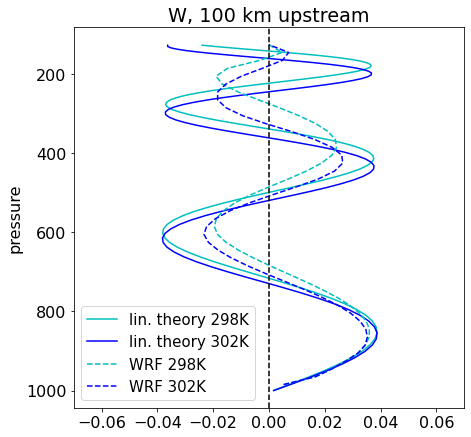

In [175]:
_,ax=plt.subplots(1,1,figsize=(7,7))

linear_w_298    .sel(distance_from_mtn=-100,method='nearest').plot(ax=ax,y='pressure',yincrease=False,color='c',label='lin. theory 298K')
linear_w_302    .sel(distance_from_mtn=-100,method='nearest').plot(ax=ax,y='pressure',yincrease=False,color='b',label='lin. theory 302K')
lmwmean_11_298_p.sel(distance_from_mtn=-100,method='nearest').plot(ax=ax,y='pressure',yincrease=False,color='c',linestyle='--',label='WRF 298K')
lmwmean_11_302_p.sel(distance_from_mtn=-100,method='nearest').plot(ax=ax,y='pressure',yincrease=False,color='b',linestyle='--',label='WRF 302K')
ax.axvline(0.,color='k',linestyle='--')
ax.set_title("W, 100 km upstream")
ax.legend(fontsize=15)
ax.set_xlim(-0.07,0.07)

# Sensitivity in SB04 theory

In [37]:
from orographicPrecipitation.precip_extremes_scaling import moist_adiabatic_lapse_rate

In [47]:
import sys; import os
p = os.path.abspath('../..')
if p not in sys.path:
    sys.path.append(p)
from orographicPrecipitation.precip_model_functions import qsat,humidsat

def HwCw(temp_surface,ps,gamma,gamma_m):
    """Compute water vapor scale height and coefficient Cw assuming a moist adiabatic atmosphere
     - temp_surface = surface temperature (np.array)
     - ps = surface pressure (np.array)
     - gamma = environment lapse rate
    """
    L=2.5e6
    Hw = 461.*temp_surface**2/(L*gamma)
    Cw = humidsat(temp_surface,ps/100)[0]*100/287./temp_surface*gamma_m/gamma
    return Hw,Cw

def smith_theory_N(xx,hx,u,N,gamma_m,ts=300.,tau=2000):
    ps=100000.
    gamma_d = 9.81/1004.
    gamma = gamma_d - ts*N**2/9.81
    Hw,Cw = HwCw(ts,ps,gamma,gamma_m)

    tau_c=tau
    tau_f=tau
    P0=4. #mm/day
    
    k=k_vector(len(xx),xx[1]-xx[0])
    
    P=np.maximum(P0+86400*np.real(np.fft.ifft(Cw*np.fft.fft(hx)*1j*u*k/(1-Hw*m_exponent(k,N,u))/(1+1j*u*k*tau_c)/(1+1j*u*k*tau_f))),0.)
    return P

In [33]:
deepchannel_p = extract_wrfpro('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.3km/')
deeptmean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.3km/diags/wrf.T_PL.days100-250.nc')
deeptmean   = deeptmean.where(deeptmean >100.)  
deeptmean_p = change_coords_pl(deepchannel_p,deeptmean)[1:-4]


In [59]:
def avg_malr(T):
    Gamma_m = 1000.*moist_adiabatic_lapse_rate(np.array(T),100.*np.array(T.pressure),'era')
    Gamma_m = xr.DataArray(Gamma_m,coords={'pressure':T.pressure},dims={'pressure'})
    return Gamma_m.sel(pressure=slice(900.,699.)).mean('pressure')

print('297K: %.2f K/km'%avg_malr(tmean_p.sel(distance_from_mtn=slice(-200,-400)).mean('distance_from_mtn')-3))
print('300K: %.2f K/km'%avg_malr(tmean_p.sel(distance_from_mtn=slice(-200,-400)).mean('distance_from_mtn')))
print('303K: %.2f K/km'%avg_malr(tmean_p.sel(distance_from_mtn=slice(-200,-400)).mean('distance_from_mtn')+3))


297K: 4.62 K/km
300K: 4.32 K/km
303K: 4.06 K/km


In [48]:
def sensitivity_SB04(N0,u0,param):
    """Unit sensitivity (% change in max precip per percent change in input param)"""
    x,hx = topographic_profile(kind='cos')
    ts0=300.;tsm=297.;tsp=303.
    gamma_m0=4.32;gamma_mm = 4.62;gamma_mp=4.06
    Plin   = smith_theory_N(x,hx,u0,N0,gamma_m0,ts0)-4.
    if param=='N':
        Plin_m = smith_theory_N(x,hx,u0,N0*0.99,gamma_m0,ts0)-4.
        Plin_p = smith_theory_N(x,hx,u0,N0*1.01,gamma_m0,ts0)-4.
    elif param=='u':
        Plin_m = smith_theory_N(x,hx,u0*0.99,N0,gamma_m0,ts0)-4.
        Plin_p = smith_theory_N(x,hx,u0*1.01,N0,gamma_m0,ts0)-4.
    elif param=='T':
        Plin_m = smith_theory_N(x,hx,u0,N0,gamma_mm,tsm)-4.
        Plin_p = smith_theory_N(x,hx,u0,N0,gamma_mp,tsp)-4.
    else:
        raise ValueError('Param must be N,u or T')
    return (Plin_p.max()-Plin_m.max())/Plin.max() / 0.02
sensitivity_SB04 = np.vectorize(sensitivity_SB04)

In [49]:
N_=np.linspace(1e-2,1.4e-2,20)
u_=np.linspace(8,12,20)
uu,NN = np.meshgrid(u_,N_)
sensitivitiesN = sensitivity_SB04(NN,uu,'N')
sensitivitiesu = sensitivity_SB04(NN,uu,'u')
sensitivitiesT = sensitivity_SB04(NN,uu,'T')

Below, we plot unit sensitivities of the maximum P' to three parameters, i.e. $S_\mathrm{param} = \dfrac{\mathrm{d}\ln(\max P')}{\mathrm{d}\ln \mathrm{param}}$ (for a x % increase in the parameter, what is the percent increase in max P' ?).

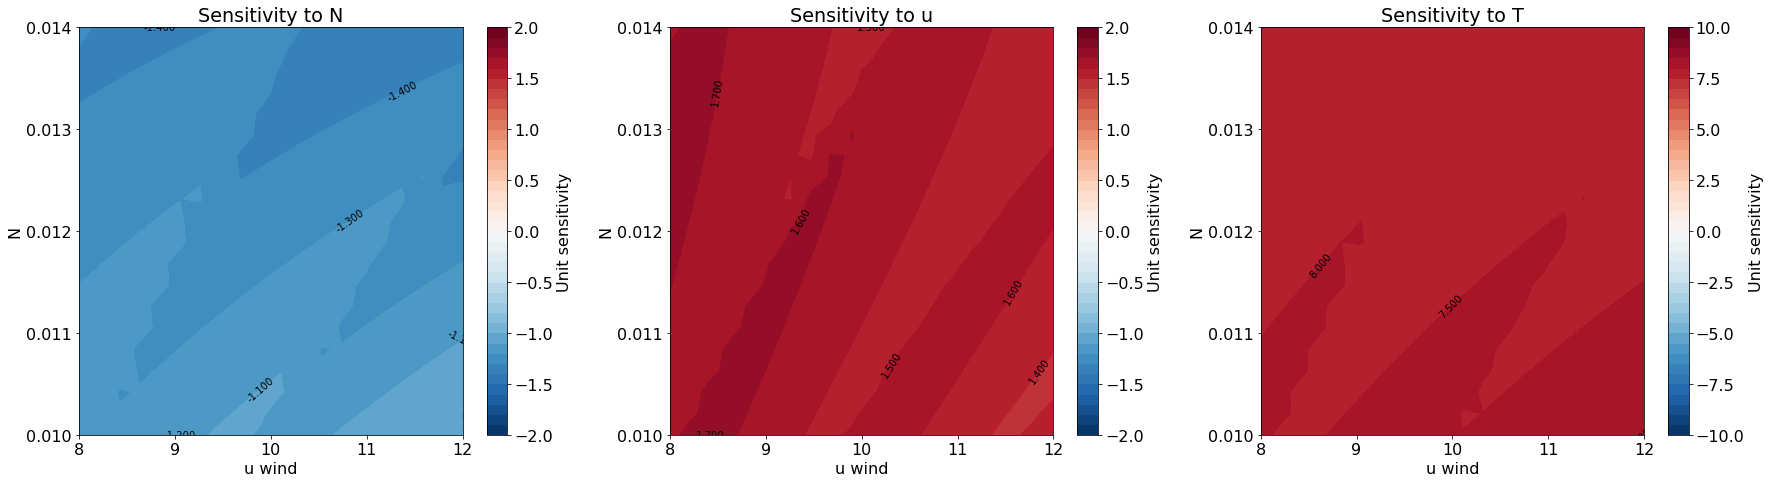

In [57]:
fig,axs=plt.subplots(1,3,figsize=(25,7))
for ax,sens,ttl,lvls in zip(axs,(sensitivitiesN,sensitivitiesu,sensitivitiesT),('N','u','T'),(np.arange(-2,2.1,0.1),np.arange(-2,2.1,0.1),np.arange(-10,10.5,0.5))):
    cf=ax.contourf(uu,NN,sens,cmap=plt.cm.RdBu_r,levels = lvls)
    fig.colorbar(cf,ax=ax,label='Unit sensitivity')
    cf.clabel(colors='k',fontsize=10,inline=False)
    ax.set_xlabel('u wind')
    ax.set_ylabel('N')
    ax.set_title("Sensitivity to "+ttl)
    ax.set_yticks(np.arange(0.01,0.015,0.001))
fig.tight_layout()

In [62]:
sensu = 1.5;sensN=-1.3;sensT=7.5
print("Hence, u decreases by 2%%/K, N increases by 1%%/K so -2*(%.2f) + 1*(%.2f) + (%.2f) = %.2f %%/K (change in max P')"%(sensu,sensN,sensT,-2*sensu+sensN+sensT))
print('Note that there will also be an increase in mean P')



Hence, u decreases by 2%/K, N increases by 1%/K so -2*(1.50) + 1*(-1.30) + (7.50) = 3.20 %/K (change in max P')
Note that there will also be an increase in mean P


# How does our theory depend on the specific slices we choose?

The troposphere gets deeper as the surface warms. Two effects are combined:
 - in height coordinates, the atmosphere thickens between two fixed pressure levels due to increased temperatures. Hypsometric equation: $z_2-z_1 = R\overline{T}/g \ln(p_1/p_2)$. A 1K increase yields a 0.3-0.5%/K thickening. Virtual temperature effects change this by a negligible factor.
 - deepening in pressure coordinates (the tropopause is getting higher). 4%/K upward shift in Singh&OGorman 2013. Abbott et al 2019: omega profile invariant in q*/q*_surf coordinate. 
 

In [49]:
tref_298 = lmtmean_11_298_p.sel(distance_from_mtn=slice(-2000,-5000)).mean('distance_from_mtn')
tref_302 = lmtmean_11_302_p.sel(distance_from_mtn=slice(-2000,-5000)).mean('distance_from_mtn')

In [50]:
ref_struct = tref_298*0
t_ma_298 = ref_struct+ (1/units.K)*mpcalc.moist_lapse(np.array(ref_struct.pressure)*units.hPa, np.array([298.])*units.K,ref_pressure = 1000.*units.hPa)
t_ma_302 = ref_struct+ (1/units.K)*mpcalc.moist_lapse(np.array(ref_struct.pressure)*units.hPa, np.array([302.])*units.K,ref_pressure = 1000.*units.hPa)


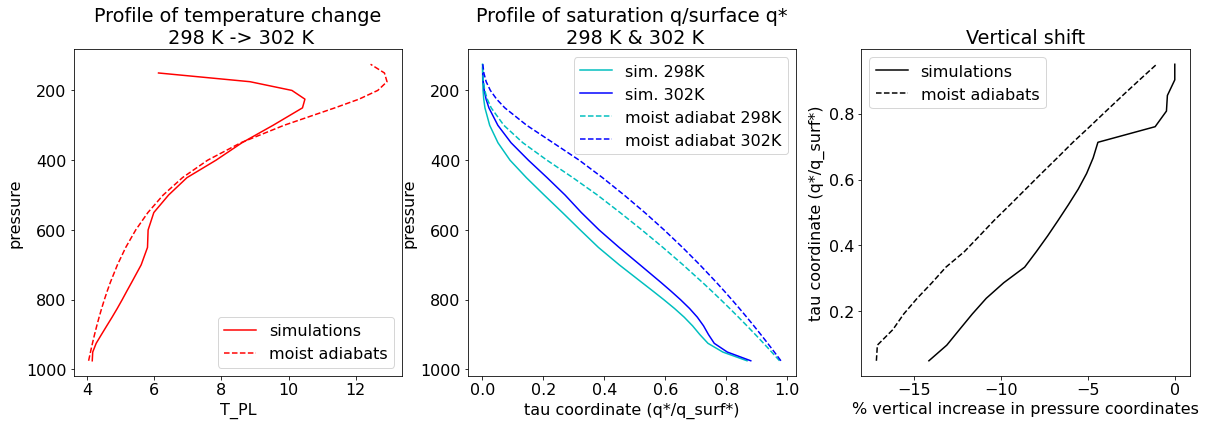

In [54]:
_,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(20,6))

(tref_302-tref_298).plot(ax=ax1,y='pressure',yincrease=False,color='red',label='simulations')
(t_ma_302-t_ma_298).plot(ax=ax1,y='pressure',yincrease=False,color='red',linestyle='--',label='moist adiabats')

qstar_298 = qsat(tref_298,tref_298.pressure);qstar_ma_298 = qsat(t_ma_298,t_ma_298.pressure)
qstar_302 = qsat(tref_302,tref_302.pressure);qstar_ma_302 = qsat(t_ma_302,t_ma_302.pressure)
qstar_surf_298 = qsat(298,1000.)
qstar_surf_302 = qsat(302,1000.)
tau_298 = qstar_298/qstar_surf_298;tau_ma_298 = qstar_ma_298/qstar_surf_298
tau_302 = qstar_302/qstar_surf_302;tau_ma_302 = qstar_ma_302/qstar_surf_302
tau_298.plot(ax=ax2,y='pressure',yincrease=False,color='c',label='sim. 298K')
tau_302.plot(ax=ax2,y='pressure',yincrease=False,color='b',label='sim. 302K')
tau_ma_298.plot(ax=ax2,y='pressure',yincrease=False,color='c',linestyle='--',label='moist adiabat 298K')
tau_ma_302.plot(ax=ax2,y='pressure',yincrease=False,color='b',linestyle='--',label='moist adiabat 302K')
ax2.set_xlabel("tau coordinate (q*/q_surf*)")


ax3.set_ylabel("tau coordinate (q*/q_surf*)")
ax3.set_xlabel("% vertical increase in pressure coordinates")
taus=np.linspace(0.05,0.95,20)
pcts=[(np.interp(tau,tau_302[::-1],tau_302.pressure[::-1])/np.interp(tau,tau_298[::-1],tau_298.pressure[::-1])-1)*100 for tau in taus]
pcts_ma=[(np.interp(tau,tau_ma_302[::-1],tau_ma_302.pressure[::-1])/np.interp(tau,tau_ma_298[::-1],tau_ma_298.pressure[::-1])-1)*100 for tau in taus]
ax3.plot(pcts,taus, color='k',label='simulations')
ax3.plot(pcts_ma,taus, color='k',linestyle='--',label='moist adiabats')

ax1.set_title("Profile of temperature change\n 298 K -> 302 K")
ax2.set_title("Profile of saturation q/surface q*\n 298 K & 302 K")
ax3.set_title("Vertical shift")

for a in (ax1,ax2,ax3):
    a.legend()

## +/- 4% change in slice height with the linear theory

In [59]:
def linear_precip_theory_N_slice(xx,hx,U,N,qfact=1,tauT=3,tauq=11,P0=4.,Td_effect=1,m_effect=1,slice_shift=1):
    pT_ov_g = 8e3 #mass of troposphere in kg/m2
    
    z=np.arange(0,10000,100)
    k=k_vector(len(xx),xx[1]-xx[0])
    
    tauT*=3600
    tauq*=3600
    
    Lq=compute_Lq(5,U,tauq)
    
    _,dq0dz,_ = lapse_rates()
    N0=0.01
    if Td_effect:
        ds0dz = cp*300/g*N**2
    else:
        ds0dz = cp*300/g*N0**2
    chi = pT_ov_g * (ds0dz/tauT - qfact*dq0dz/tauq)/ Lc * 86400
    
    if not m_effect:
        N=N0
    
    zbot=1000*slice_shift
    ztop=3000*slice_shift 
    z_slice = z[np.where((z>=zbot) & (z<=ztop))]
    Pprimehat = 1j*k/(1j*k + 1/Lq) * chi * np.fft.fft(hx) * np.exp( m_exponent(k[:,None],N,U)  *  z_slice[None,:]).mean(axis=1) 
    
    P = P0 + np.real(np.fft.ifft(Pprimehat))
    P = np.maximum(0.,P)
    return P

### Absolute change

Change in max P': -4% to base, -19.21 %; base to +4%, -17.14 %


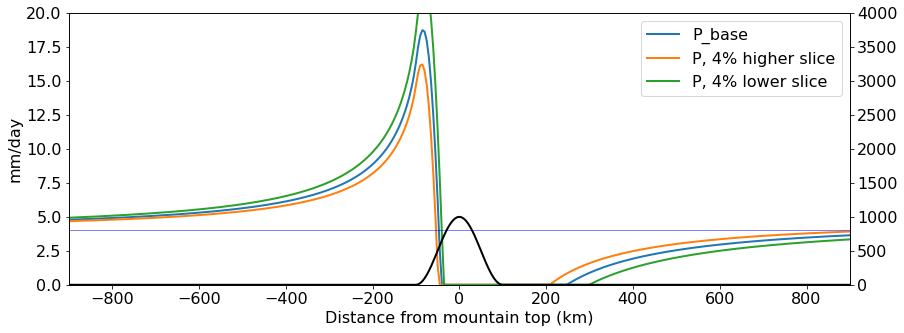

In [10]:
lw=2

u_base = 10
N_base = 0.012

x,hx = topographic_profile(kind='cos')
Plin    = linear_precip_theory_N      (x,hx,u_base,N_base,qfact=1,tauT=7.5,tauq=27.5,P0=4.)
Plin_p4 = linear_precip_theory_N_slice(x,hx,u_base,N_base,qfact=1,tauT=7.5,tauq=27.5,P0=4.,slice_shift=1.04)
Plin_m4 = linear_precip_theory_N_slice(x,hx,u_base,N_base,qfact=1,tauT=7.5,tauq=27.5,P0=4.,slice_shift=0.96)

fig,ax=plt.subplots(1,1,figsize=(14,5))
ax2=ax.twinx()
ax.plot(x/1000,Plin   ,label = "P_base",linewidth=lw)
ax.plot(x/1000,Plin_p4,label = "P, 4% higher slice",linewidth=lw)
ax.plot(x/1000,Plin_m4,label = "P, 4% lower slice" ,linewidth=lw)

# mountain
ax2.plot(x/1000,hx,label=r"$h(x)$",color='k',linewidth=2)
ax.axhline(4.,linestyle='-',linewidth=0.5,color='b')
ax.set_xlabel('Distance from mountain top (km)')
ax.set_ylabel('mm/day')
ax.set_xlim(-900,900)
ax.set_ylim(0,20)
ax2.set_ylim(0,4000)
ax.legend()
#ax.set_ylim(10,20)
#ax.set_xlim(-200,0)
print("Change in max P': -4%% to base, %.2f %%; base to +4%%, %.2f %%"%( ((Plin.max()-4)/(Plin_m4.max()-4)-1)*100 , ((Plin_p4.max()-4)/(Plin.max()-4)-1)*100 ))



### Change in sensitivity

In [25]:
def sensitivity_T(N0,u0,slice_shift_pct=0):
    """Sensitivity in %/K"""
    x,hx = topographic_profile(kind='cos')
    Plin   = linear_precip_theory_N(x,hx,u0,N0,tauT=7.5,tauq=27.5,P0 = 4.)-4.
    Plin_m = linear_precip_theory_N_slice(x,hx,u0,N0/1.014,qfact=1/1.07,tauT=7.5,tauq=27.5,P0 = 4.,slice_shift=1-slice_shift_pct/100)-4.
    Plin_p = linear_precip_theory_N_slice(x,hx,u0,N0*1.014,qfact=1.07,tauT=7.5,tauq=27.5,P0 = 4.,slice_shift=1+slice_shift_pct/100)-4.
    return (Plin_p.max()-Plin_m.max())/Plin.max()*100 / 2

sensitivity_T = np.vectorize(sensitivity_T)

In [26]:
N_=np.linspace(1e-2,1.4e-2,20)
u_=np.linspace(8,12,20)
uu,NN = np.meshgrid(u_,N_)
sensitivitiesT = sensitivity_T(NN,uu)
sensitivitiesT_slice_shift = sensitivity_T(NN,uu,slice_shift_pct=4)

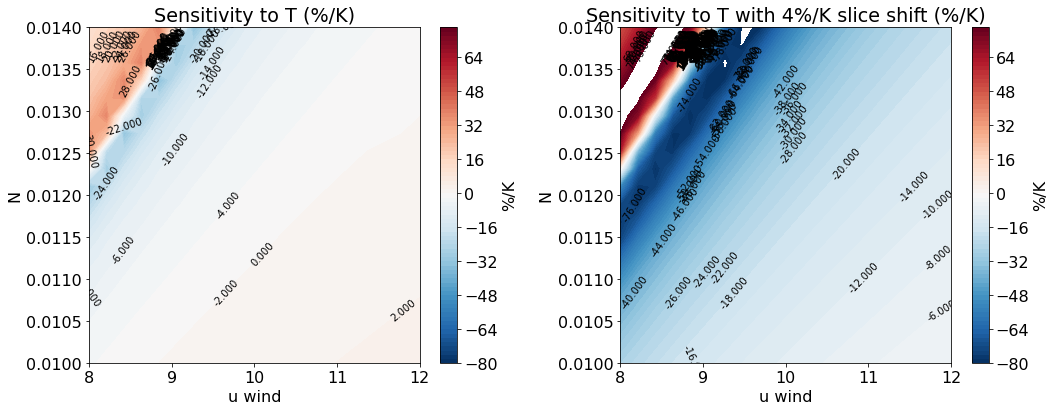

In [28]:
fig,axs=plt.subplots(1,2,figsize=(15,6))
for ax,sens,ttl in zip(axs,(sensitivitiesT,sensitivitiesT_slice_shift),('Sensitivity to T (%/K)','Sensitivity to T with 4%/K slice shift (%/K)')):
    cf=ax.contourf(uu,NN,sens,cmap=plt.cm.RdBu_r,levels = np.arange(-80,80,2))
    fig.colorbar(cf,ax=ax,label='%/K')
    cf.clabel(colors='k',fontsize=10,inline=False)
    ax.set_xlabel('u wind')
    ax.set_ylabel('N')
    ax.set_title(ttl)
    #ax.set_yticks(np.arange(0.01,0.015,0.001))
fig.tight_layout()

In [31]:
def sensitivity_T_bis(N0,u0,slice_shift=1):
    """Sensitivity in %/K"""
    x,hx = topographic_profile(kind='cos')
    Plin   = linear_precip_theory_N_slice(x,hx,u0,N0,tauT=7.5,tauq=27.5,P0 = 4.,slice_shift=slice_shift)-4.
    Plin_m = linear_precip_theory_N_slice(x,hx,u0,N0/1.014,qfact=1/1.07,tauT=7.5,tauq=27.5,P0 = 4.,slice_shift=slice_shift)-4.
    Plin_p = linear_precip_theory_N_slice(x,hx,u0,N0*1.014,qfact=1.07,tauT=7.5,tauq=27.5,P0 = 4.,slice_shift=slice_shift)-4.
    return (Plin_p.max()-Plin_m.max())/Plin.max()*100 / 2

sensitivity_T_bis = np.vectorize(sensitivity_T_bis)

In [32]:
N_=np.linspace(1e-2,1.4e-2,20)
u_=np.linspace(8,12,20)
uu,NN = np.meshgrid(u_,N_)
sensitivitiesT_096 = sensitivity_T_bis(NN,uu,slice_shift=0.96)
sensitivitiesT_104 = sensitivity_T_bis(NN,uu,slice_shift=1.04)

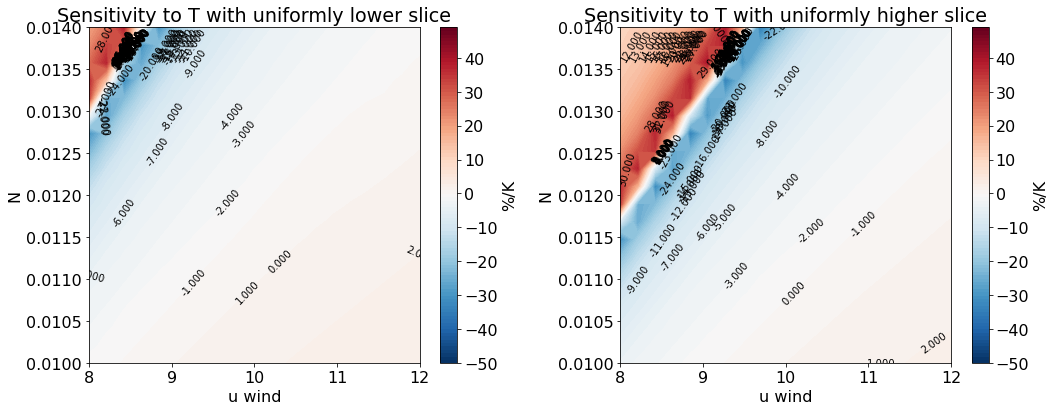

In [36]:
fig,axs=plt.subplots(1,2,figsize=(15,6))
for ax,sens,ttl in zip(axs,(sensitivitiesT_096,sensitivitiesT_104),('Sensitivity to T with uniformly lower slice','Sensitivity to T with uniformly higher slice')):
    cf=ax.contourf(uu,NN,sens,cmap=plt.cm.RdBu_r,levels = np.arange(-50,50,1))
    fig.colorbar(cf,ax=ax,label='%/K')
    cf.clabel(colors='k',fontsize=10,inline=False)
    ax.set_xlabel('u wind')
    ax.set_ylabel('N')
    ax.set_title(ttl)
    #ax.set_yticks(np.arange(0.01,0.015,0.001))
fig.tight_layout()

## With simulation T/q profiles

In [264]:
from scipy.interpolate import interp1d
def hatprime_hr(var,p1=875,p2=700):
    """Vertically average variable between two pressure levels, and take deviation from upstream value"""
    plevs=np.arange(875,600,-12.5)
    var_itp=interp1d(var.pressure,var,kind='quadratic',axis=0)(plevs)
    var_itp = xr.DataArray(var_itp,coords={'pressure':plevs,'distance_from_mtn':var.distance_from_mtn},dims=['pressure','distance_from_mtn'])
    varhat = var_itp.sel(pressure=slice(p1,p2)).integrate('pressure')/(p2-p1)
    return varhat - varhat[2200:2400].mean('distance_from_mtn')

In [270]:
lmtmean_11_298_p_hat_prime_hr = hatprime_hr(lmtmean_11_298_p[4:])
lmtmean_11_302_p_hat_prime_hr = hatprime_hr(lmtmean_11_302_p[4:-1])
lmtmean_11_302_p_hat_prime_hr_shift = hatprime_hr(lmtmean_11_302_p[4:-1],875*0.96,700*0.96)

lmqmean_11_298_p_hat_prime_hr = hatprime_hr(lmqmean_11_298_p[4:])
lmqmean_11_302_p_hat_prime_hr = hatprime_hr(lmqmean_11_302_p[4:-1])
lmqmean_11_302_p_hat_prime_hr_shift = hatprime_hr(lmqmean_11_302_p[4:-1],875*0.96,700*0.96)

increase in max, without shift: T = 2.6%/K,  q = 5.1%/K
increase in max, with shift: T = -4.3%/K,  q = -7.9%/K


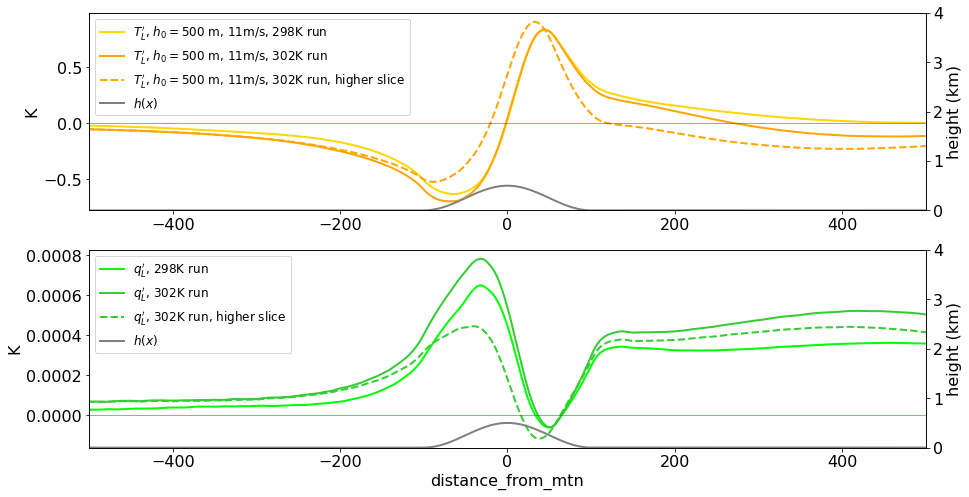

In [273]:
fig,(ax,ax2) = plt.subplots(2,1,figsize=(15,8))
axm=ax.twinx()
ax2m=ax2.twinx()
lw=2

# Panel a : temperature deviations
lmtmean_11_298_p_hat_prime_hr.plot(ax=ax,color='gold'  ,linewidth=lw,label=r"$T_L'$, $h_0=500$ m, 11m/s, 298K run")
lmtmean_11_302_p_hat_prime_hr.plot(ax=ax,color='orange',linewidth=lw,label=r"$T_L'$, $h_0=500$ m, 11m/s, 302K run")
lmtmean_11_302_p_hat_prime_hr_shift.plot(ax=ax,color='orange',linestyle='--',linewidth=lw,label=r"$T_L'$, $h_0=500$ m, 11m/s, 302K run, higher slice")
ax.axhline(0.,linestyle='-',linewidth='0.5',color='red')

# Panel b : moisture deviations
lmqmean_11_298_p_hat_prime_hr.plot(ax=ax2,color='lime'     ,linewidth=lw,label=r"$q_L'$, 298K run")
lmqmean_11_302_p_hat_prime_hr.plot(ax=ax2,color='limegreen',linewidth=lw,label=r"$q_L'$, 302K run")
lmqmean_11_302_p_hat_prime_hr_shift.plot(ax=ax2,color='limegreen',linestyle='--',linewidth=lw,label=r"$q_L'$, 302K run, higher slice")

ax2.axhline(0.,linestyle='-',linewidth='0.5',color='green')


for a,am in (ax,axm),(ax2,ax2m):
    a.set_xlim(-500,500)
    a.set_ylabel("K")
    a.legend(fontsize=20)
    
    am.plot(hrdist,hrhgt/2000,label=r"$h(x)$",color='gray',linewidth=2)
    am.set_ylabel('height (km)')
    am.set_ylim(0,4)
    
    lines, labels = a.get_legend_handles_labels()
    lines2, labels2 = am.get_legend_handles_labels()
    a.legend(lines + lines2, labels + labels2,fontsize=12,loc=2)

ax.set_xlabel('')
print("increase in max, without shift: T = %.1f%%/K,  q = %.1f%%/K"%(100*(lmtmean_11_302_p_hat_prime_hr.min()/lmtmean_11_298_p_hat_prime_hr.min()-1)/4,100*(lmqmean_11_302_p_hat_prime_hr.max()/lmqmean_11_298_p_hat_prime_hr.max()-1)/4))
print("increase in max, with shift: T = %.1f%%/K,  q = %.1f%%/K"%(100*(lmtmean_11_302_p_hat_prime_hr_shift.min()/lmtmean_11_298_p_hat_prime_hr.min()-1)/4,100*(lmqmean_11_302_p_hat_prime_hr_shift.max()/lmqmean_11_298_p_hat_prime_hr.max()-1)/4))


## Sensitivity to U with a wide range of slices

In [38]:
def sensitivity_U(N0,u0,slice_shift=1):
    """Sensitivity in %/K"""
    x,hx = topographic_profile(kind='cos')
    Plin   = linear_precip_theory_N_slice(x,hx,u0,N0,tauT=7.5,tauq=27.5,P0 = 4.,slice_shift=slice_shift)-4.
    Plin_m = linear_precip_theory_N_slice(x,hx,u0*0.99,N0,tauT=7.5,tauq=27.5,P0 = 4.,slice_shift=slice_shift)-4.
    Plin_p = linear_precip_theory_N_slice(x,hx,u0*1.01,N0,tauT=7.5,tauq=27.5,P0 = 4.,slice_shift=slice_shift)-4.
    return (Plin_p.max()-Plin_m.max())/Plin.max()/0.02

sensitivity_U = np.vectorize(sensitivity_U)

In [39]:
N_=np.linspace(1e-2,1.4e-2,20)
slice_=np.linspace(1,1.5,20)
slices,NN = np.meshgrid(slice_,N_)
sensitivitiesU = sensitivity_U(NN,10,slice_shift=slices)

In [55]:
slice_hr2=np.linspace(1,1.5,100)
sensitivitiesU_hr2= sensitivity_U(0.012,10,slice_shift=slice_hr2)

Text(0.5, 0, 'Slice vertical shift factor')

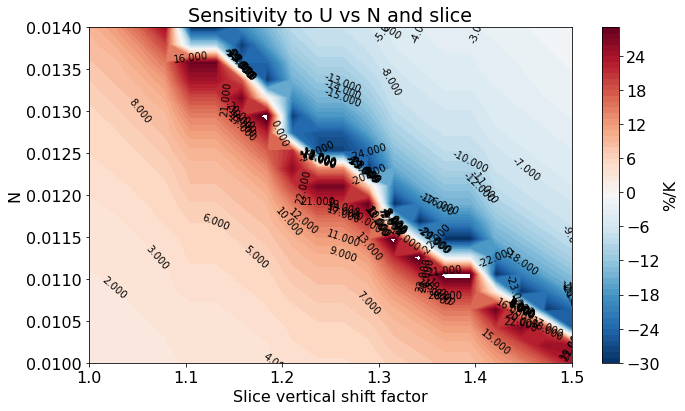

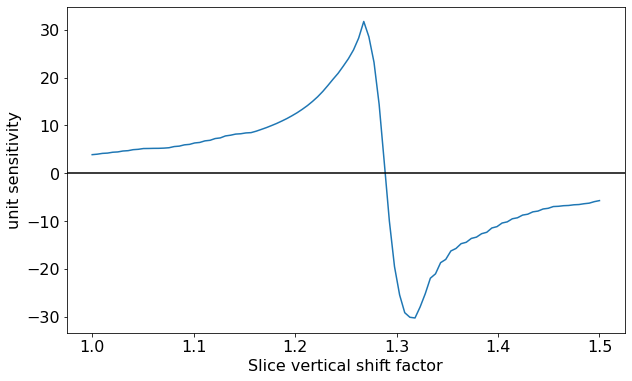

In [61]:
fig,ax=plt.subplots(1,1,figsize=(10,6))
cf=ax.contourf(slices,NN,sensitivitiesU,cmap=plt.cm.RdBu_r,levels = np.arange(-30,30,1))
fig.colorbar(cf,ax=ax,label='%/K')
cf.clabel(colors='k',fontsize=10,inline=False)
ax.set_xlabel('Slice vertical shift factor')
ax.set_ylabel('N')
ax.set_title("Sensitivity to U vs N and slice")
fig.tight_layout()

fig,ax=plt.subplots(1,1,figsize=(10,6))
ax.plot(slice_hr2,sensitivitiesU_hr2)
ax.axhline(0.,color='k')
ax.set_ylabel('unit sensitivity')
ax.set_xlabel('Slice vertical shift factor')


# Misc: Domain integrated precip in linear theory

In [ ]:
def halflinear_precip_theory(U,kind='agnesi',a=100e3,A=1000,tauT=3,tauq=11,P0 = 4.):
    pT_ov_g = 8e3 #mass of troposphere in kg/m2
    
    tauT*=3600
    tauq*=3600
    
    Lq=compute_Lq(5,U,tauq)

    xx,TdL,qdL = linear_TdL_qdL(U,kind=kind,a=a,A=A)
    conv=1/ Lc * 86400 * pT_ov_g # conversion factor from J/kg/s to kg/m2/day (=mm/day if density of water is 1000km/m2)

    #Solve for <q_m>/tauq_tilde
    def fun(qmb_ov_tauq_tilde,x):
        ix=np.argmin((xx-x)**2) # Get index of current location
        return -1/Lq* (np.maximum(0.,qmb_ov_tauq_tilde+(qdL*conv/tauq-TdL*conv/tauT)[ix])-P0)
    qmb_ov_tauq_tilde = odeint(fun,P0,xx)[:,0]
    
    return xx,hx,np.maximum(0.,qmb_ov_tauq_tilde+qdL*conv/tauq-TdL*conv/tauT)

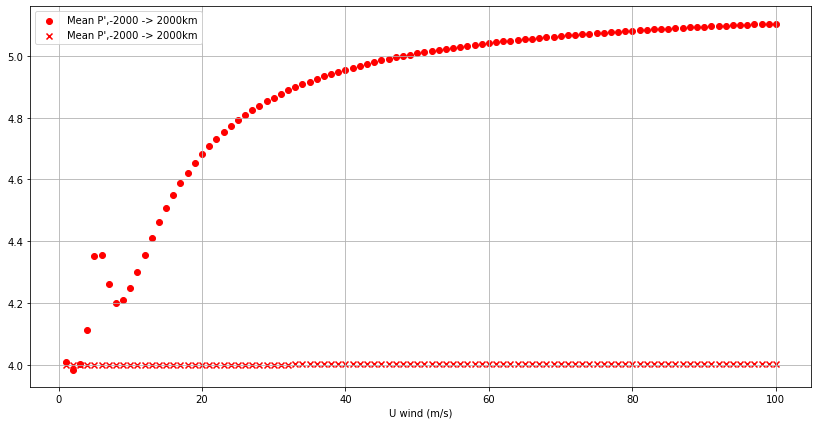

In [74]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
us = range(1,101)
means=[]
meanshl=[]
for u in us:
    x,hx,_,Plin = linear_precip_theory(u,kind='cos',tauT=7.5,tauq=27.5,P0 = 4.)
    x,hx,Phalflin = halflinear_precip_theory(u,kind='cos',tauT=7.5,tauq=27.5,P0 = 4.)
    idx1=np.argmin((x+2000e3)**2)
    idx2=np.argmin((x-2000e3)**2)
    means.append(np.mean(Plin[idx1:idx2]))
    meanshl.append(np.mean(Phalflin[idx1:idx2]))
ax.scatter(us,means,marker='o',color='r',label="Mean P',-2000 -> 2000km")
ax.scatter(us,meanshl,marker='x',color='r',label="Mean P',-2000 -> 2000km")
ax.grid()
ax.set_xlabel('U wind (m/s)')
ax.legend()

In [3]:
import os
import sys
p = os.path.abspath('../..')
if p not in sys.path:
    sys.path.append(p)

In [4]:
from orographicPrecipitation.wrfProcessing.wrf_hr_utils import *

test = extract_wrfpro('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.11mps.298K.3km/')
test = extract_wrfpro('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.11mps.302K.3km/')

test = extract_wrfout('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.3km/')
test = extract_wrfpro('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.3km/')
test = extract_wrfout('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.3km/')
test = extract_wrfpro('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.3km/')
test = extract_wrfout('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.dry.3km/')
test = extract_wrfpro('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.dry.3km/')
test = extract_wrfout('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.new.3km/')
test = extract_wrfpro('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.new.3km/')
test = extract_wrfout('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.12mps.3km/')
test = extract_wrfpro('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.12mps.3km/')
test = extract_wrfout('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.296K.3km/')
test = extract_wrfpro('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.296K.3km/')
